# **OPEN UNIVERSITY LEARNING ANALYTICS DATASET ANALYSIS**

The Open University Learning Analytics Dataset (OULAD) contains anonymized data on students enrolled in online courses offered by the Open University. The dataset is composed of multiple interconnected tables that capture student demographics, academic performance, course structure, and online learning behavior. It includes information such as student registration and withdrawal dates, assessment details and scores, final results, prior educational background, and interaction logs from the Virtual Learning Environment (VLE). Together, these components provide a comprehensive view of student engagement and progression throughout online modules, enabling analysis of learning behavior, performance patterns, and factors influencing student success and withdrawal.

# **DATA LOADING AND INITIAL SETUP**

In [110]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report

# Remove Warnings
import warnings
warnings.filterwarnings("ignore")

In [111]:
# Load datasets
studentregistration = pd.read_csv('studentRegistration.csv')
studentinfo = pd.read_csv('studentInfo.csv')
studentvle = pd.read_csv('studentVle.csv')
studentassessment = pd.read_csv('studentAssessment.csv')
courses = pd.read_csv('courses.csv')
vle = pd.read_csv('vle.csv')
assessments = pd.read_csv('assessments.csv')

# **INITIAL DATA INSPECTION & DATA UNDERSTANDING**

In [112]:
print("studentRegistration Columns:")
print(studentregistration.columns.tolist(), "\n")

print("studentInfo Columns:")
print(studentinfo.columns.tolist(), "\n")

print("studentVle Columns:")
print(studentvle.columns.tolist(), "\n")

print("studentAssessment Columns:")
print(studentassessment.columns.tolist(), "\n")

print("courses Columns:")
print(courses.columns.tolist(), "\n")

print("vle columns:")
print(vle.columns.tolist(), "\n")

print("assessments columns:")
print(assessments.columns.tolist())

studentRegistration Columns:
['code_module', 'code_presentation', 'id_student', 'date_registration', 'date_unregistration'] 

studentInfo Columns:
['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result'] 

studentVle Columns:
['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click'] 

studentAssessment Columns:
['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score'] 

courses Columns:
['code_module', 'code_presentation', 'module_presentation_length'] 

vle columns:
['id_site', 'code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to'] 

assessments columns:
['code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'weight']


In [113]:
studentregistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [114]:
studentregistration.tail()

,code_module,code_presentation,id_student,date_registration,date_unregistration
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0
32592,GGG,2014J,2684003,-28.0,NaN


In [115]:
studentinfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [116]:
studentinfo.tail()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn
32592,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction


In [117]:
studentvle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [118]:
studentvle.tail()

,code_module,code_presentation,id_student,id_site,date,sum_click
3095534,CCC,2014J,693302,909097,239,20
3095535,CCC,2014J,692928,909342,239,1
3095536,CCC,2014J,692928,909018,239,4
3095537,CCC,2014J,692928,1019025,239,5
3095538,CCC,2014J,692928,1019025,239,5


In [119]:
studentassessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [120]:
studentassessment.tail()

,id_assessment,id_student,date_submitted,is_banked,score
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0
173911,37443,558486,224,0,80.0


In [121]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [122]:
courses.tail()

,code_module,code_presentation,module_presentation_length
17,FFF,2013B,240
18,FFF,2014B,241
19,GGG,2013J,261
20,GGG,2014J,269
21,GGG,2014B,241


In [123]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [124]:
vle.tail()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN
6363,897100,GGG,2014J,resource,NaN,NaN


In [125]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [126]:
assessments.tail()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0
205,GGG,2014J,37444,Exam,229.0,100.0


# **DATA PREPARATION & HANDLING MISSING VALUES**

In [127]:
print("studentregistration:", studentregistration.shape)
print("studentinfo:", studentinfo.shape)
print("studentvle:", studentvle.shape)
print("studentassessment:", studentassessment.shape)
print("courses:", courses.shape)
print("vle:", vle.shape)
print("assessments:", assessments.shape)

studentregistration: (32593, 5)
studentinfo: (32593, 12)
studentvle: (3095539, 6)
studentassessment: (173912, 5)
courses: (22, 3)
vle: (6364, 6)
assessments: (206, 6)


In [128]:
# Integrate registration details with student demographic and performance data to create a unified student-level dataset
data = pd.merge(studentregistration, studentinfo, on=['id_student', 'code_module', 'code_presentation'], how='inner')

In [129]:
# Merge course-level information into the student-level dataset
data = pd.merge(data, courses, on=['code_module', 'code_presentation'], how='inner')

In [130]:
data.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,30268,-92.0,12.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,268
3,AAA,2013J,31604,-52.0,NaN,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,268
4,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,268


In [131]:
data.tail()

,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
32588,GGG,2014J,2640965,-4.0,NaN,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,269
32589,GGG,2014J,2645731,-23.0,NaN,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,269
32590,GGG,2014J,2648187,-129.0,NaN,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,269
32591,GGG,2014J,2679821,-49.0,101.0,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,269
32592,GGG,2014J,2684003,-28.0,NaN,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,269


In [132]:
# Merge assessment data with individual student assessment results
student_assesment_data = assessments.merge(studentassessment,on=['id_assessment'],how="inner")

In [133]:
student_assesment_data.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0


In [134]:
student_assesment_data.tail()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0
173911,GGG,2014J,37437,TMA,173.0,0.0,653374,172,0,50.0


In [135]:
print("Maximum Weight:", student_assesment_data.weight.max())
print("Minimum Weight:", student_assesment_data.weight.min())

Maximum Weight: 100.0
Minimum Weight: 0.0


In [136]:
# Check for missing values in the merged student assessment dataset
student_assesment_data.isna().sum()

code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2865
weight                  0
id_student              0
date_submitted          0
is_banked               0
score                 173
dtype: int64

In [137]:
# Analyse missing assessment scores by assessment type to understand non-submission patterns
missing_score_records = student_assesment_data[student_assesment_data['score'].isnull()]

In [138]:
print(missing_score_records.groupby(['assessment_type'])['id_assessment'].count())

assessment_type
TMA    173
Name: id_assessment, dtype: int64


In [139]:
# Filter missing TMA scores and count non-submissions by module and presentation
tma_missing_score_records = missing_score_records[missing_score_records['assessment_type'] == 'TMA']

In [140]:
print(tma_missing_score_records.groupby(['code_module', 'code_presentation'])['id_assessment'].count())

code_module  code_presentation
AAA          2013J                 2
             2014J                 1
BBB          2013B                16
             2013J                10
             2014B                17
             2014J                10
CCC          2014B                 5
             2014J                 6
DDD          2013B                18
             2013J                 8
             2014B                11
             2014J                12
EEE          2013J                 3
             2014B                 2
             2014J                 2
FFF          2013B                14
             2013J                12
             2014B                11
             2014J                 9
GGG          2013J                 1
             2014B                 1
             2014J                 2
Name: id_assessment, dtype: int64


In [141]:
# Flag missing scores (non-submission indicator)
student_assesment_data['score_missing'] = student_assesment_data['score'].isna().astype(int)

# Treat missing scores as non-submission
student_assesment_data['score'] = student_assesment_data['score'].fillna(0)

# Drop only rows missing critical identifiers
student_assesment_data.dropna(subset=['id_assessment', 'id_student'], inplace=True)

In [142]:
student_assesment_data.isna().sum()

code_module             0
code_presentation       0
id_assessment           0
assessment_type         0
date                 2865
weight                  0
id_student              0
date_submitted          0
is_banked               0
score                   0
score_missing           0
dtype: int64

In [143]:
student_data = student_assesment_data.merge(data, on=['code_module','code_presentation','id_student'],how="inner")

In [144]:
student_data.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,...,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0,...,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0,...,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,268
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,268
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0,...,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,268


In [145]:
student_data.tail()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
173907,GGG,2014J,37437,TMA,173.0,0.0,652462,172,0,60.0,...,M,South Region,Lower Than A Level,90-100%,35-55,0,30,N,Pass,269
173908,GGG,2014J,37437,TMA,173.0,0.0,652539,176,0,75.0,...,F,South Region,A Level or Equivalent,70-80%,0-35,0,30,N,Pass,269
173909,GGG,2014J,37437,TMA,173.0,0.0,653157,187,0,70.0,...,F,West Midlands Region,Lower Than A Level,20-30%,0-35,0,30,N,Pass,269
173910,GGG,2014J,37437,TMA,173.0,0.0,653252,171,0,70.0,...,F,East Anglian Region,No Formal quals,20-30%,0-35,0,30,Y,Pass,269
173911,GGG,2014J,37437,TMA,173.0,0.0,653374,172,0,50.0,...,F,London Region,Lower Than A Level,10-20,0-35,0,30,N,Distinction,269


In [146]:
student_data.isna().sum()

code_module                        0
code_presentation                  0
id_assessment                      0
assessment_type                    0
date                            2865
weight                             0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
score_missing                      0
date_registration                  7
date_unregistration           160857
gender                             0
region                             0
highest_education                  0
imd_band                        7697
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
module_presentation_length         0
dtype: int64

In [147]:
df = student_data.copy()

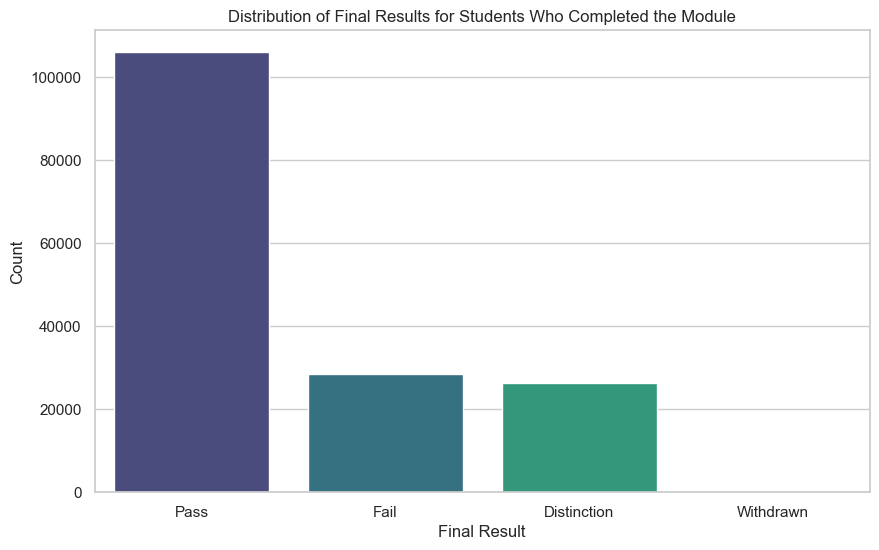

In [148]:
# Filter students who did not unregister from the module
students_completed_module = df[df['date_unregistration'].isnull()]

plt.figure(figsize=(10, 6))
sns.countplot(data=students_completed_module, x='final_result', palette='viridis')

plt.title('Distribution of Final Results for Students Who Completed the Module')
plt.xlabel('Final Result')
plt.ylabel('Count')

plt.show()

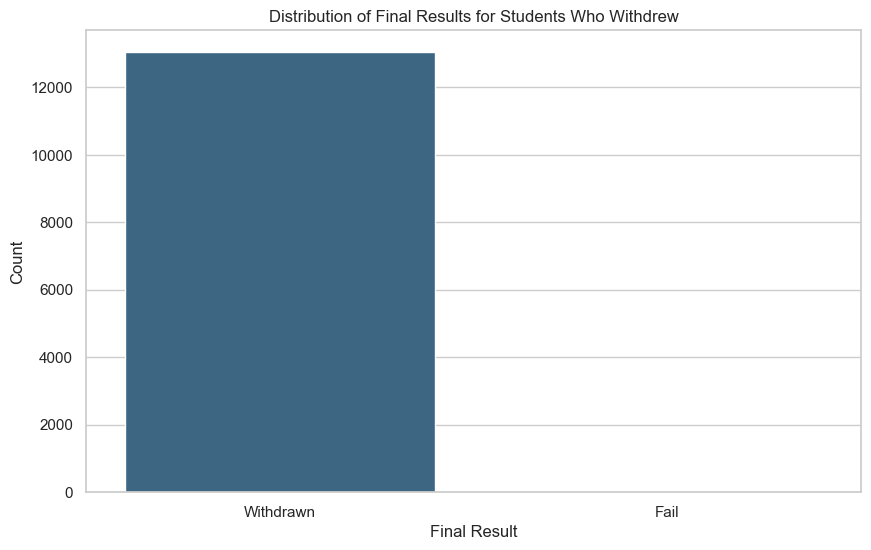

In [149]:
# Filter students who withdrew from the module
withdrawn_students = df[df['date_unregistration'].notnull()]

plt.figure(figsize=(10, 6))
sns.countplot(data=withdrawn_students, x='final_result', palette='viridis')

plt.title('Distribution of Final Results for Students Who Withdrew')
plt.xlabel('Final Result')
plt.ylabel('Count')
plt.show()

In [150]:
# Create a completion status variable based on final outcome
df['completion_status'] = df['final_result'].apply(lambda x: 'finished' if x in ['Pass', 'Fail', 'Distinction'] else 'unfinished')

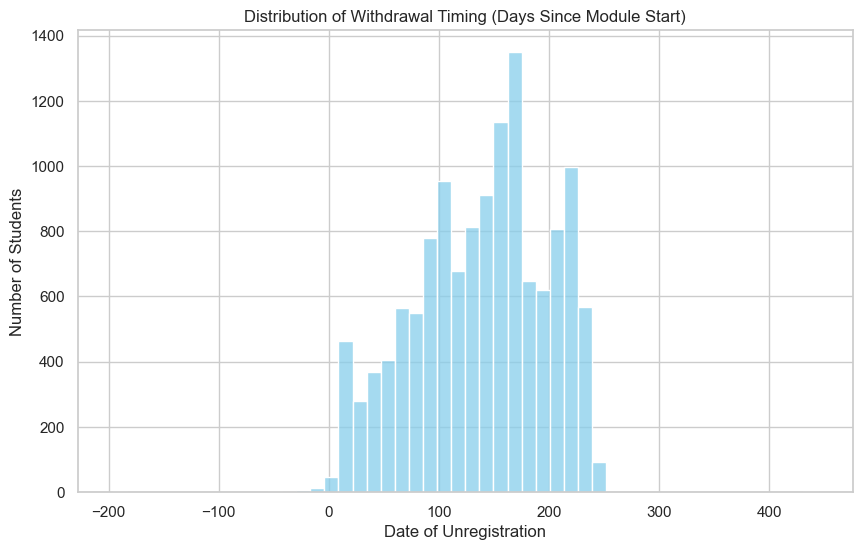

In [151]:
# Filter students who withdrew from the module
withdrawn_students = df[df['date_unregistration'].notnull()]

plt.figure(figsize=(10, 6))
sns.histplot(withdrawn_students['date_unregistration'], bins=50, color='skyblue')

plt.title('Distribution of Withdrawal Timing (Days Since Module Start)')
plt.xlabel('Date of Unregistration')
plt.ylabel('Number of Students')

plt.show()

In [152]:
df.isna().sum()

code_module                        0
code_presentation                  0
id_assessment                      0
assessment_type                    0
date                            2865
weight                             0
id_student                         0
date_submitted                     0
is_banked                          0
score                              0
score_missing                      0
date_registration                  7
date_unregistration           160857
gender                             0
region                             0
highest_education                  0
imd_band                        7697
age_band                           0
num_of_prev_attempts               0
studied_credits                    0
disability                         0
final_result                       0
module_presentation_length         0
completion_status                  0
dtype: int64

In [153]:
# Categorise students based on withdrawal timing relative to module start
def categorize_withdrawal(date):
    if pd.isnull(date):
        return "didn't withdraw"
    elif date < 0:
        return 'early withdrawal'
    elif date >= 0 and date < 70:
        return 'normal withdrawal'
    else:
        return 'late withdrawal'

df['withdrawal_status'] = df['date_unregistration'].apply(categorize_withdrawal)

df[['date_unregistration', 'withdrawal_status']].head()

,date_unregistration,withdrawal_status
0,NaN,didn't withdraw
1,NaN,didn't withdraw
2,NaN,didn't withdraw
3,NaN,didn't withdraw
4,NaN,didn't withdraw


In [154]:
df.drop(['date_unregistration'],axis=1,inplace=True)

In [155]:
df.isna().sum()

code_module                      0
code_presentation                0
id_assessment                    0
assessment_type                  0
date                          2865
weight                           0
id_student                       0
date_submitted                   0
is_banked                        0
score                            0
score_missing                    0
date_registration                7
gender                           0
region                           0
highest_education                0
imd_band                      7697
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
module_presentation_length       0
completion_status                0
withdrawal_status                0
dtype: int64

In [156]:
regions_list = df[df['imd_band'].isnull()]['region'].unique()

In [157]:
for region in regions_list:
  mode_imd_band = df[df['region'] == region]['imd_band'].mode()[0]
  df.loc[(df['imd_band'].isnull()) & (df['region'] == region), 'imd_band'] = mode_imd_band

In [158]:
# Check remaining missing values
df.isna().sum()

code_module                      0
code_presentation                0
id_assessment                    0
assessment_type                  0
date                          2865
weight                           0
id_student                       0
date_submitted                   0
is_banked                        0
score                            0
score_missing                    0
date_registration                7
gender                           0
region                           0
highest_education                0
imd_band                         0
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
module_presentation_length       0
completion_status                0
withdrawal_status                0
dtype: int64

In [159]:
# Drop rows with missing registration date (very few records)
df.dropna(subset=['date_registration'], inplace=True)

In [160]:
# Merge student VLE interaction data with VLE activity metadata
student_vle_interactions = studentvle.merge(vle, on=['code_module', 'code_presentation', 'id_site'], how='left')

In [161]:
student_vle_interactions.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,NaN,NaN
1,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
2,AAA,2013J,28400,546652,-10,1,forumng,NaN,NaN
3,AAA,2013J,28400,546614,-10,11,homepage,NaN,NaN
4,AAA,2013J,28400,546714,-10,1,oucontent,NaN,NaN


In [162]:
student_vle_interactions.tail()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
3095534,CCC,2014J,693302,909097,239,20,quiz,NaN,NaN
3095535,CCC,2014J,692928,909342,239,1,url,NaN,NaN
3095536,CCC,2014J,692928,909018,239,4,forumng,NaN,NaN
3095537,CCC,2014J,692928,1019025,239,5,forumng,NaN,NaN
3095538,CCC,2014J,692928,1019025,239,5,forumng,NaN,NaN


In [163]:
# Aggregate student VLE engagement by activity type
student_activity_engagement = student_vle_interactions.groupby(
    ['id_student', 'code_module', 'code_presentation', 'activity_type'],
    as_index=False
)['sum_click'].agg(['sum', 'count'])

In [164]:
student_activity_engagement.head()

,id_student,code_module,code_presentation,activity_type,sum,count
0,6516,AAA,2014J,dataplus,21,4
1,6516,AAA,2014J,forumng,451,175
2,6516,AAA,2014J,homepage,497,158
3,6516,AAA,2014J,oucontent,1505,184
4,6516,AAA,2014J,resource,31,19


In [165]:
student_activity_engagement.tail()

,id_student,code_module,code_presentation,activity_type,sum,count
80158,2698588,BBB,2014J,oucollaborate,7,7
80159,2698588,BBB,2014J,oucontent,233,74
80160,2698588,BBB,2014J,resource,49,36
80161,2698588,BBB,2014J,subpage,76,34
80162,2698588,BBB,2014J,url,2,2


In [166]:
# Combine aggregated VLE engagement data with student demographic and performance information
student_engagement_analysis_df = student_activity_engagement.merge(
    df,
    on=['id_student', 'code_module', 'code_presentation'],
    how='inner'
)

In [167]:
student_engagement_analysis_df['date'] = (
    student_engagement_analysis_df['date']
    .fillna(student_engagement_analysis_df['module_presentation_length'])
)

In [168]:
student_engagement_analysis_df.head()

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,...,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,completion_status,withdrawal_status
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,...,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,...,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,...,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,...,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,...,HE Qualification,80-90%,55<=,0,60,N,Pass,269,finished,didn't withdraw


In [169]:
student_engagement_analysis_df.tail()

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,...,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,completion_status,withdrawal_status
492112,2698588,BBB,2014J,url,2,2,15020,TMA,19.0,0.0,...,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
492113,2698588,BBB,2014J,url,2,2,15021,TMA,54.0,10.0,...,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
492114,2698588,BBB,2014J,url,2,2,15022,TMA,110.0,20.0,...,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
492115,2698588,BBB,2014J,url,2,2,15023,TMA,152.0,35.0,...,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw
492116,2698588,BBB,2014J,url,2,2,15024,TMA,201.0,35.0,...,HE Qualification,30-40%,0-35,0,120,N,Distinction,262,finished,didn't withdraw


In [170]:
student_engagement_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492117 entries, 0 to 492116
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_student                  492117 non-null  int64  
 1   code_module                 492117 non-null  object 
 2   code_presentation           492117 non-null  object 
 3   activity_type               492117 non-null  object 
 4   sum                         492117 non-null  int64  
 5   count                       492117 non-null  int64  
 6   id_assessment               492117 non-null  int64  
 7   assessment_type             492117 non-null  object 
 8   date                        492117 non-null  float64
 9   weight                      492117 non-null  float64
 10  date_submitted              492117 non-null  int64  
 11  is_banked                   492117 non-null  int64  
 12  score                       492117 non-null  float64
 13  score_missing 

In [171]:
student_engagement_analysis_df.isna().sum()

id_student                    0
code_module                   0
code_presentation             0
activity_type                 0
sum                           0
count                         0
id_assessment                 0
assessment_type               0
date                          0
weight                        0
date_submitted                0
is_banked                     0
score                         0
score_missing                 0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
module_presentation_length    0
completion_status             0
withdrawal_status             0
dtype: int64

In [172]:
df_eda = student_engagement_analysis_df.copy()

# **SUMMARY OF DATA PREPARATION AND PRE-EDA STEPS**



1.   Imported essential Python libraries for data manipulation, numerical analysis, and visualization (NumPy, Pandas, Matplotlib, Seaborn).
2.   Loaded multiple tables from the Open University Learning Analytics Dataset (OULAD), including:

*   Student registration data
*   Student demographic information
*   Assessment details and assessment results
*   Course and module metadata
*   Virtual Learning Environment (VLE) interaction data

3.  Conducted initial data inspection using .head(), .tail(), .shape(), .info(), and .columns() to understand dataset structure, size, and schema.

4.  Identified key identifiers (id_student, code_module, code_presentation) required for merging datasets.

5.  Examined column definitions and data types across all datasets to ensure consistency.

6.  Assessed missing values in each dataset and quantified missingness at the column level.

7.  Performed step-by-step dataset merging to create a consolidated student-level dataset combining demographics, registration details, assessment performance, and course information.

8.  Addressed missing values by:

*  Distinguishing between critical and non-critical features
*  Removing or filtering records with invalid or unusable entries
*  Creating indicator variables for missing assessment scores where appropriate

9.  Validated data integrity after merging by rechecking dataset dimensions, null values, and data types.

10. Engineered additional features to support analysis, including:
*   Student completion status derived from final results
*   Withdrawal timing relative to module start
*   Categorical withdrawal status (early, mid, late, or no withdrawal)

11. Filtered datasets to analyze specific student cohorts (e.g., completed vs withdrawn students).

12. Aggregated VLE interaction logs to compute student engagement metrics such as total clicks and activity counts.

13. Merged engagement metrics with demographic and performance data to produce a final analysis-ready dataset.

14. Ensured the final dataset was clean, consistent, and well-structured for subsequent exploratory data analysis and modeling tasks.


# **EXPLORATORY DATA ANALYSIS**

# UNIVARIATE ANALYSIS

In [173]:
# Set aesthetic parameters for the plots
sns.set(style="whitegrid")

# SUMMARY STATISTICS
print("Summary Statistics for Numerical Variables:")
display(df_eda.describe())

print("\nValue Counts for Key Categorical Variables:")
categorical_cols = ['gender', 'final_result', 'highest_education', 'withdrawal_status']
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df_eda[col].value_counts())

Summary Statistics for Numerical Variables:


,id_student,sum,count,id_assessment,date,weight,date_submitted,is_banked,score,score_missing,date_registration,num_of_prev_attempts,studied_credits,module_presentation_length
count,4.921170e+05,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000,492117.000000
mean,7.062923e+05,164.813636,46.757980,17189.370489,109.789717,13.922004,109.832591,0.006336,75.629921,0.000912,-67.045064,0.127102,78.163983,254.515564
std,5.594839e+05,451.192906,82.622017,5380.076213,68.050534,18.038385,67.722904,0.079346,20.693759,0.030192,48.720316,0.423627,36.601354,14.575470
min,6.516000e+03,1.000000,1.000000,1752.000000,12.000000,0.000000,-11.000000,0.000000,0.000000,0.000000,-311.000000,0.000000,30.000000,234.000000
25%,5.008190e+05,10.000000,6.000000,14997.000000,47.000000,1.000000,49.000000,0.000000,64.000000,0.000000,-95.000000,0.000000,60.000000,240.000000
50%,5.806840e+05,45.000000,23.000000,15012.000000,109.000000,9.000000,109.000000,0.000000,80.000000,0.000000,-53.000000,0.000000,60.000000,262.000000
75%,6.325360e+05,133.000000,53.000000,24286.000000,159.000000,18.000000,164.000000,0.000000,92.000000,0.000000,-29.000000,0.000000,120.000000,268.000000
max,2.698588e+06,13154.000000,1727.000000,24299.000000,269.000000,100.000000,285.000000,1.000000,100.000000,1.000000,81.000000,6.000000,630.000000,269.000000



Value Counts for Key Categorical Variables:

--- gender ---
gender
F    332965
M    159152
Name: count, dtype: int64

--- final_result ---
final_result
Pass           293765
Distinction     83680
Fail            76903
Withdrawn       37769
Name: count, dtype: int64

--- highest_education ---
highest_education
A Level or Equivalent          229747
Lower Than A Level             166494
HE Qualification                84874
Post Graduate Qualification      6965
No Formal quals                  4037
Name: count, dtype: int64

--- withdrawal_status ---
withdrawal_status
didn't withdraw      454361
late withdrawal       31593
normal withdrawal      6035
early withdrawal        128
Name: count, dtype: int64


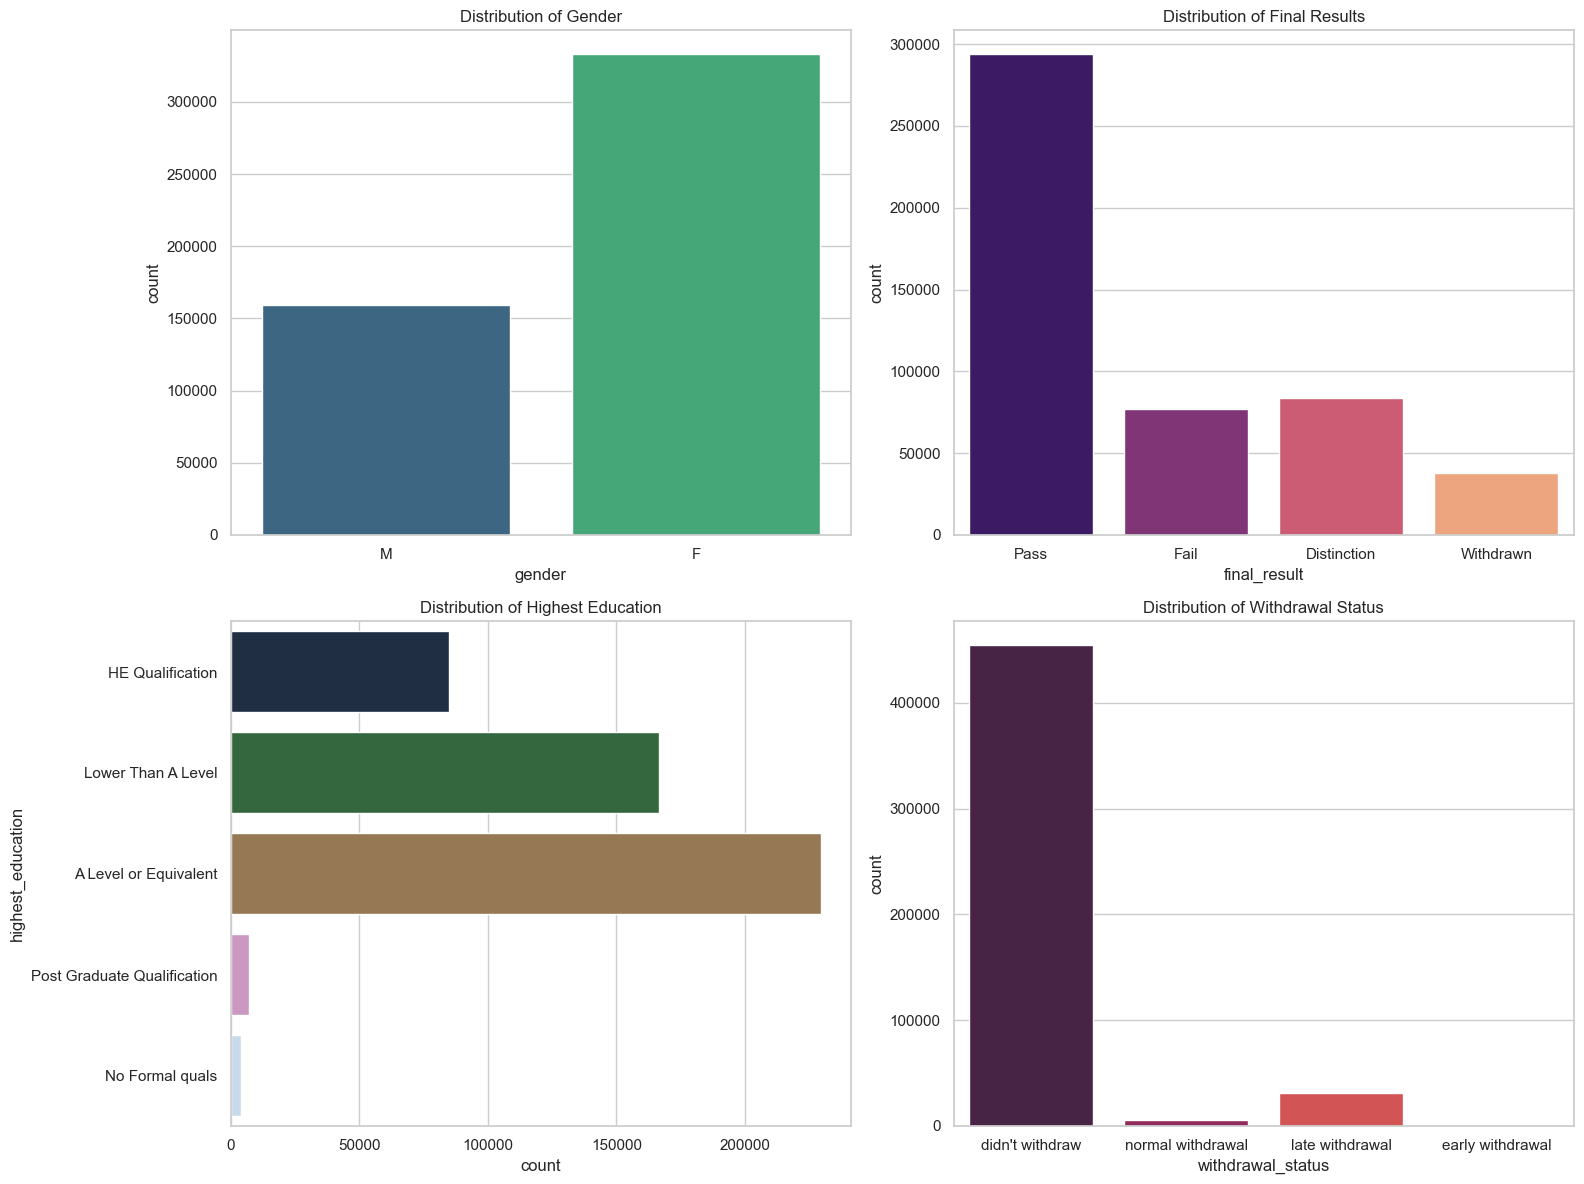

In [174]:
# VISUALIZING CATEGORICAL VARIABLES (Count Plots)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(data=df_eda, x='gender', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Distribution of Gender')

sns.countplot(data=df_eda, x='final_result', ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Distribution of Final Results')

sns.countplot(data=df_eda, y='highest_education', ax=axes[1, 0], palette='cubehelix')
axes[1, 0].set_title('Distribution of Highest Education')

sns.countplot(data=df_eda, x='withdrawal_status', ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('Distribution of Withdrawal Status')

plt.tight_layout()
plt.show()

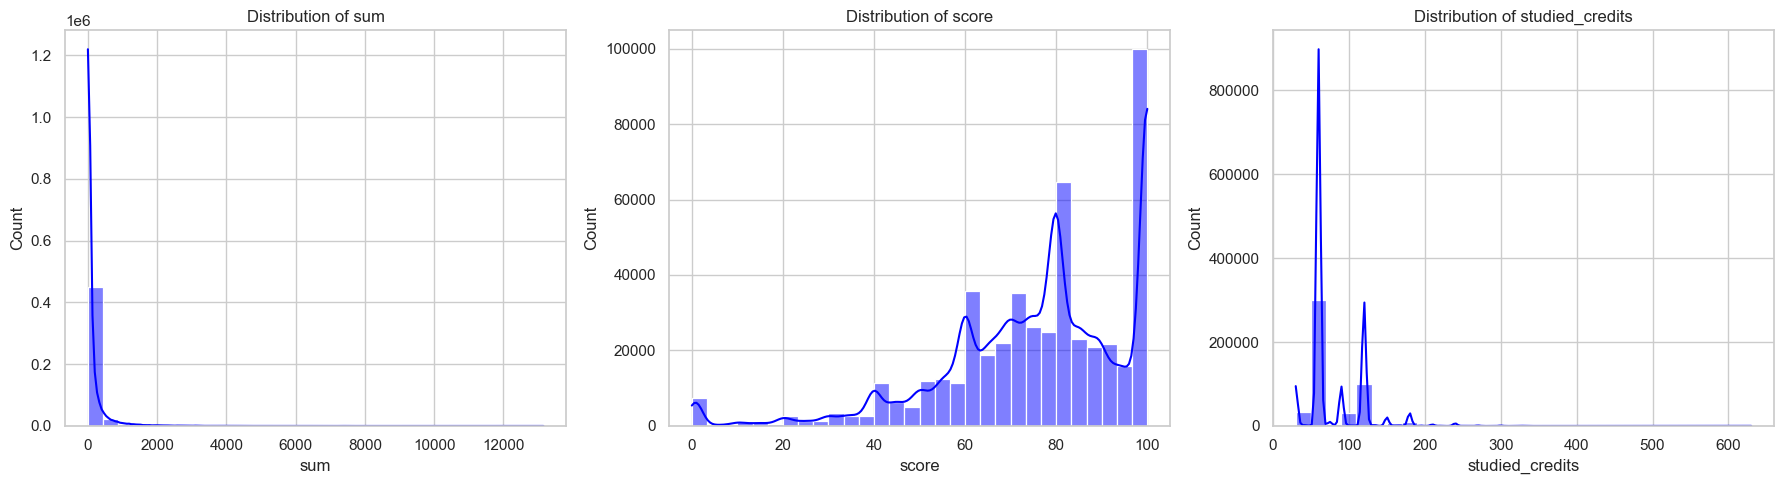

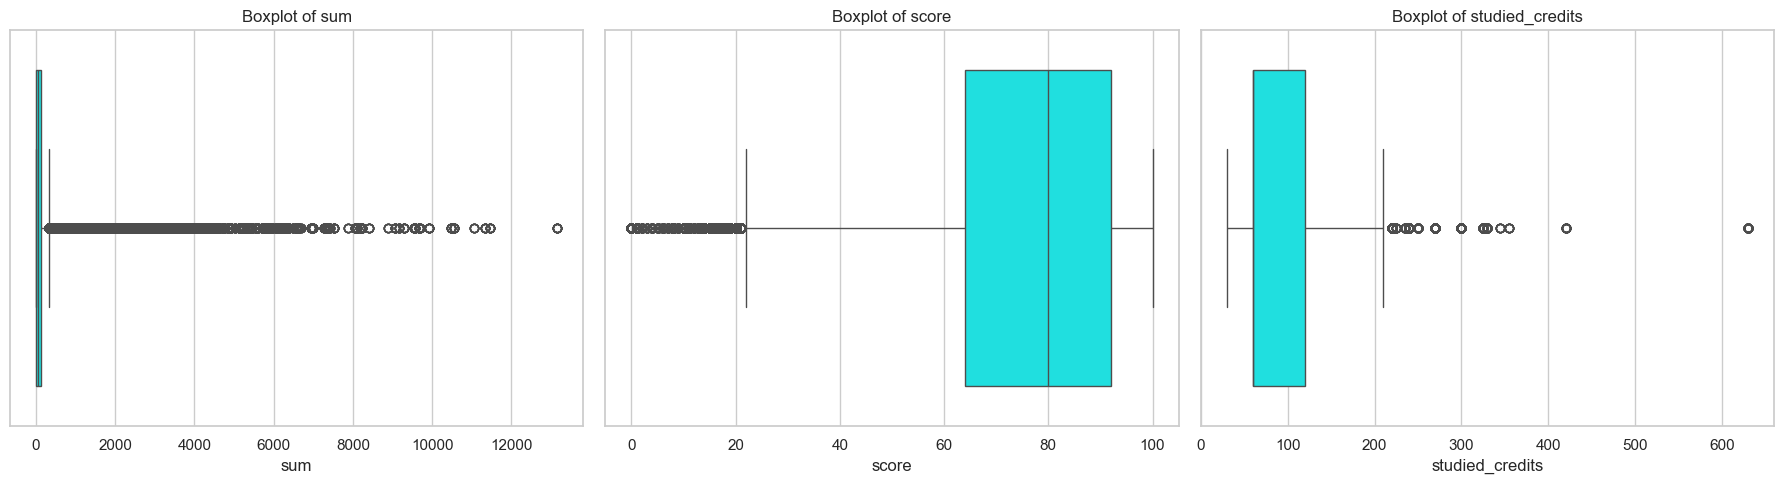

In [175]:
# VISUALIZING NUMERICAL VARIABLES (Histograms & Boxplots)
# Engagement metrics (clicks) and scores
numerical_features = ['sum', 'score', 'studied_credits']

plt.figure(figsize=(18, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_eda[feature], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(18, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df_eda[feature], color='cyan')
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

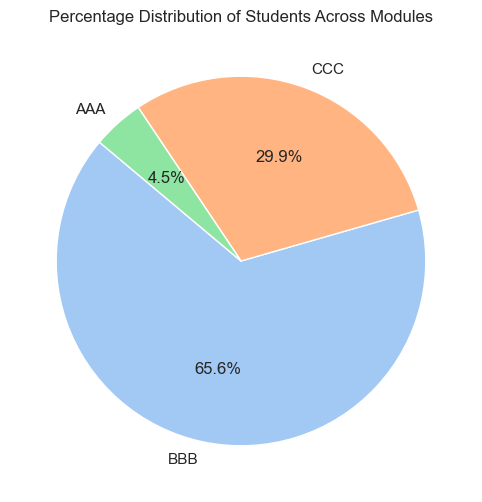

In [176]:
# MODULE DISTRIBUTION
plt.figure(figsize=(10, 6))
df_eda['code_module'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Percentage Distribution of Students Across Modules')
plt.ylabel('')
plt.show()

# BI-VARIATE ANALYSIS

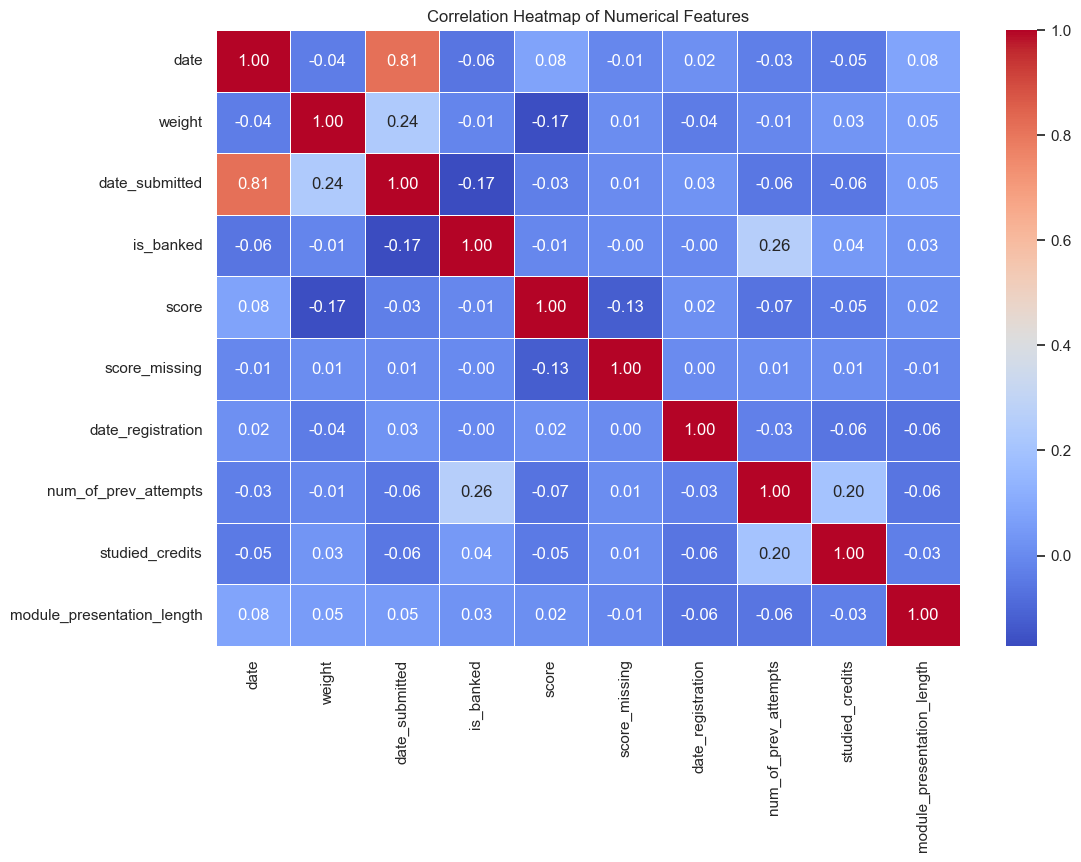

In [177]:
# --- NUMERICAL VS. NUMERICAL: CORRELATION HEATMAP ---
# Identifies strong relationships between numeric variables (e.g., Score vs. Clicks)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
# Dropping ID columns for a cleaner correlation matrix
corr_matrix = numeric_df.drop(columns=['id_student', 'id_assessment'], errors='ignore').corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

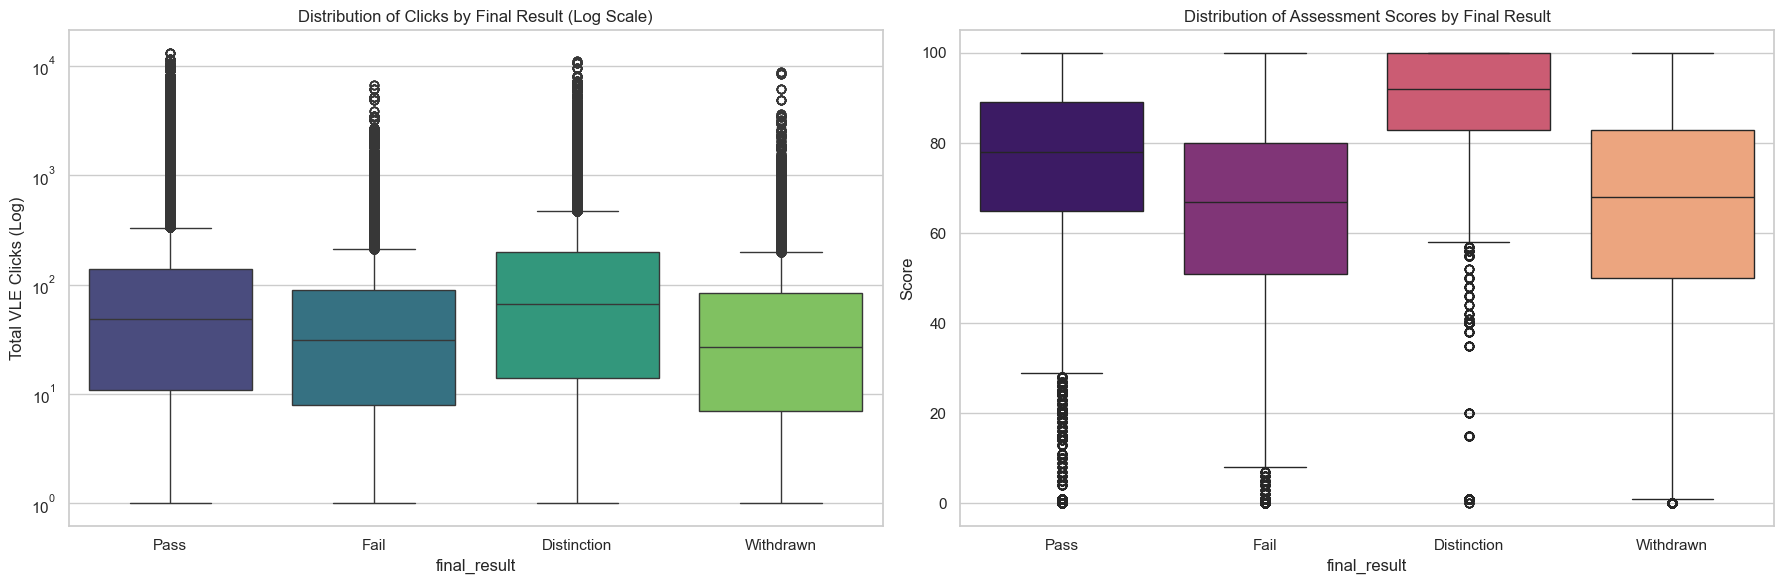

In [178]:
# --- CATEGORICAL VS. NUMERICAL: PERFORMANCE BY OUTCOME ---
# Use the final merged dataframe that contains the 'sum' column
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total Clicks (sum) vs. Final Result
# Updated 'data' to use the correctly merged dataframe
sns.boxplot(data=student_engagement_analysis_df, x='final_result', y='sum', ax=axes[0], palette='viridis')
axes[0].set_yscale('log')
axes[0].set_title('Distribution of Clicks by Final Result (Log Scale)')
axes[0].set_ylabel('Total VLE Clicks (Log)')

# Assessment Score vs. Final Result
sns.boxplot(data=student_engagement_analysis_df, x='final_result', y='score', ax=axes[1], palette='magma')
axes[1].set_title('Distribution of Assessment Scores by Final Result')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

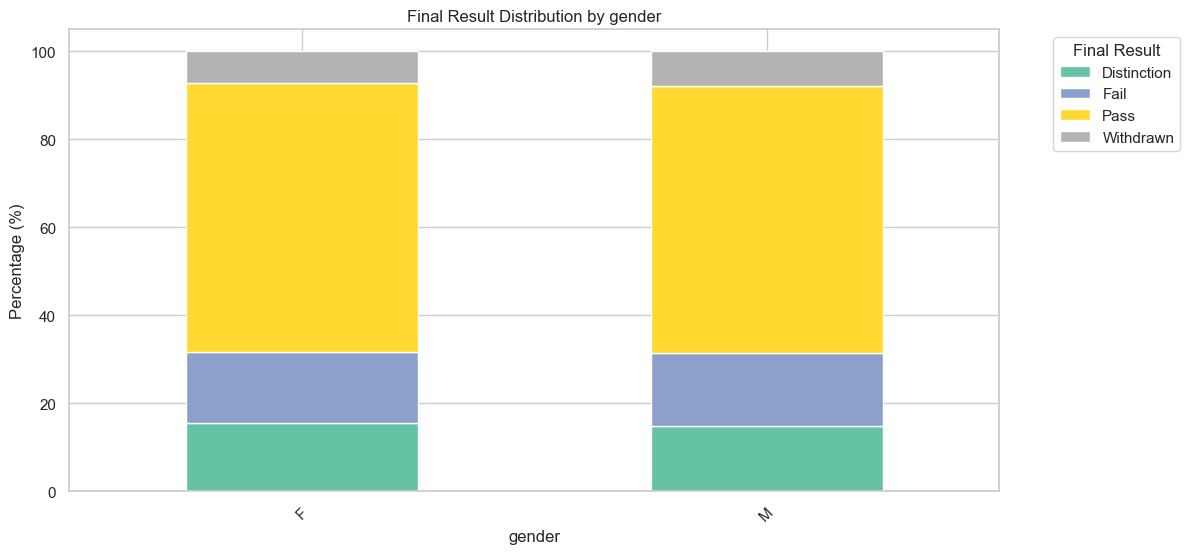

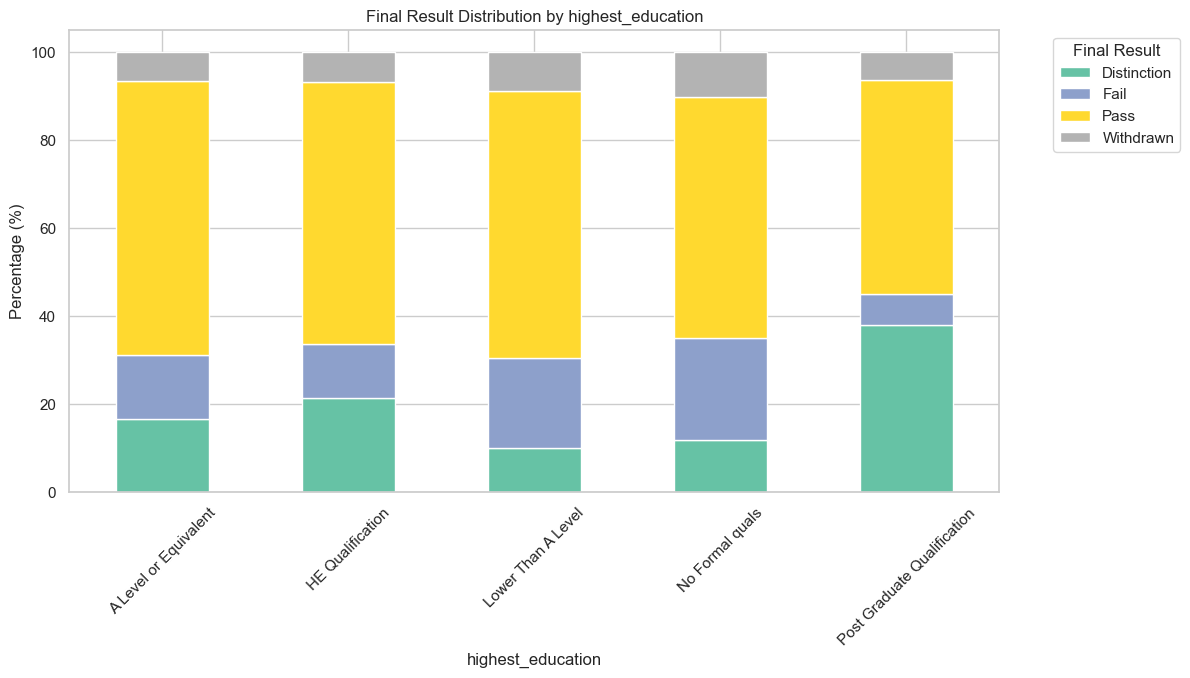

In [179]:
# --- CATEGORICAL VS. CATEGORICAL: DEMOGRAPHICS VS. OUTCOME ---
# Using cross-tabulation to see success rates across different groups
def plot_success_rate(feature):
    cross_tab = pd.crosstab(df[feature], df['final_result'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
    plt.title(f'Final Result Distribution by {feature}')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.show()

# Success rate by Gender
plot_success_rate('gender')

# Success rate by Education level
plot_success_rate('highest_education')

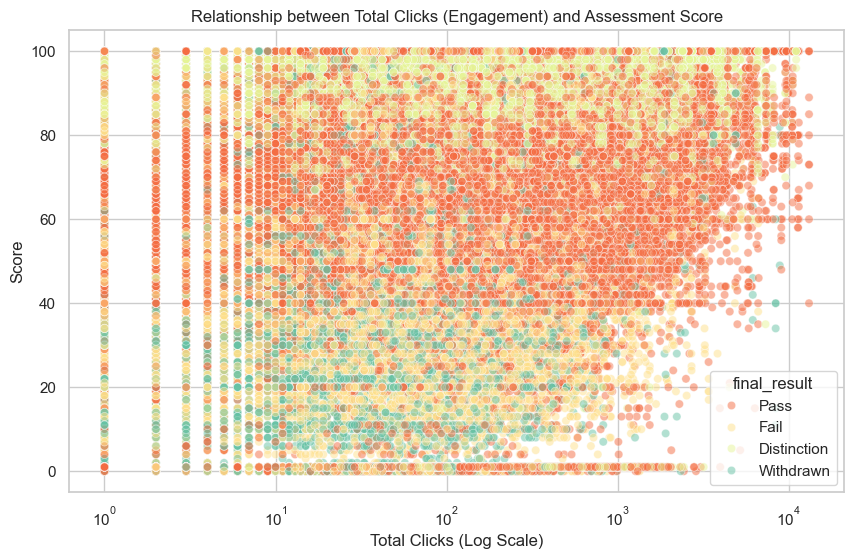

In [180]:
# --- SCATTER PLOT: SCORE VS. ENGAGEMENT ---
# Directly checking the linear relationship between clicks and scores
plt.figure(figsize=(10, 6))

# Use the final combined dataframe that includes the 'sum' (VLE clicks) column
sns.scatterplot(data=student_engagement_analysis_df, x='sum', y='score', hue='final_result', alpha=0.5, palette='Spectral')

plt.xscale('log') # Log scale for clicks to handle outliers
plt.title('Relationship between Total Clicks (Engagement) and Assessment Score')
plt.xlabel('Total Clicks (Log Scale)')
plt.ylabel('Score')
plt.show()

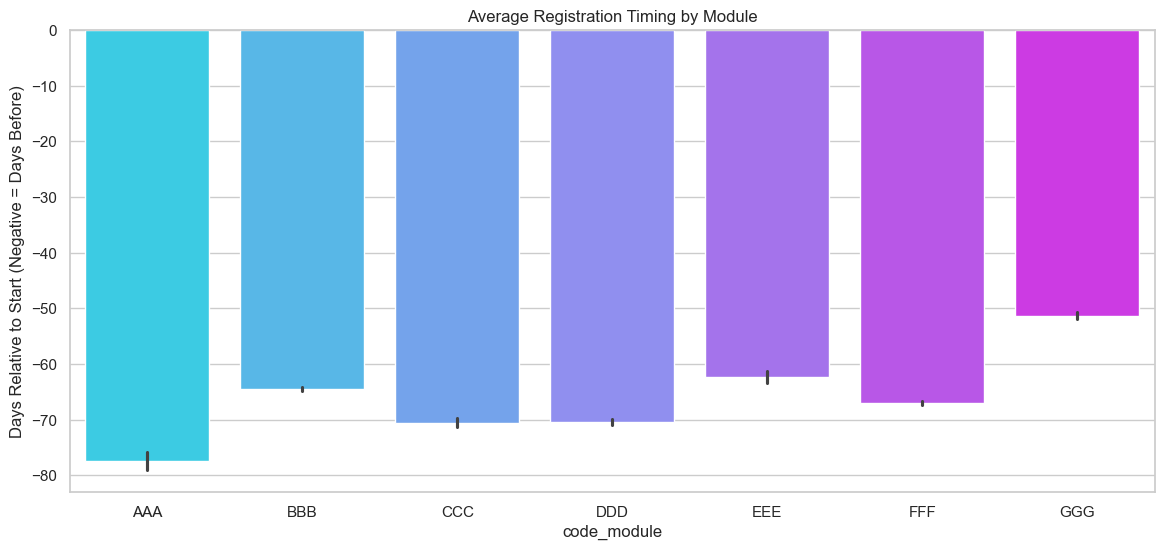

In [181]:
# --- GROUPED ANALYSIS: REGISTRATION TIMING BY MODULE ---
# Does registration lead time vary significantly between modules?
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x='code_module', y='date_registration', palette='cool')
plt.title('Average Registration Timing by Module')
plt.ylabel('Days Relative to Start (Negative = Days Before)')
plt.show()

# MULTIVARIATE ANALYSIS

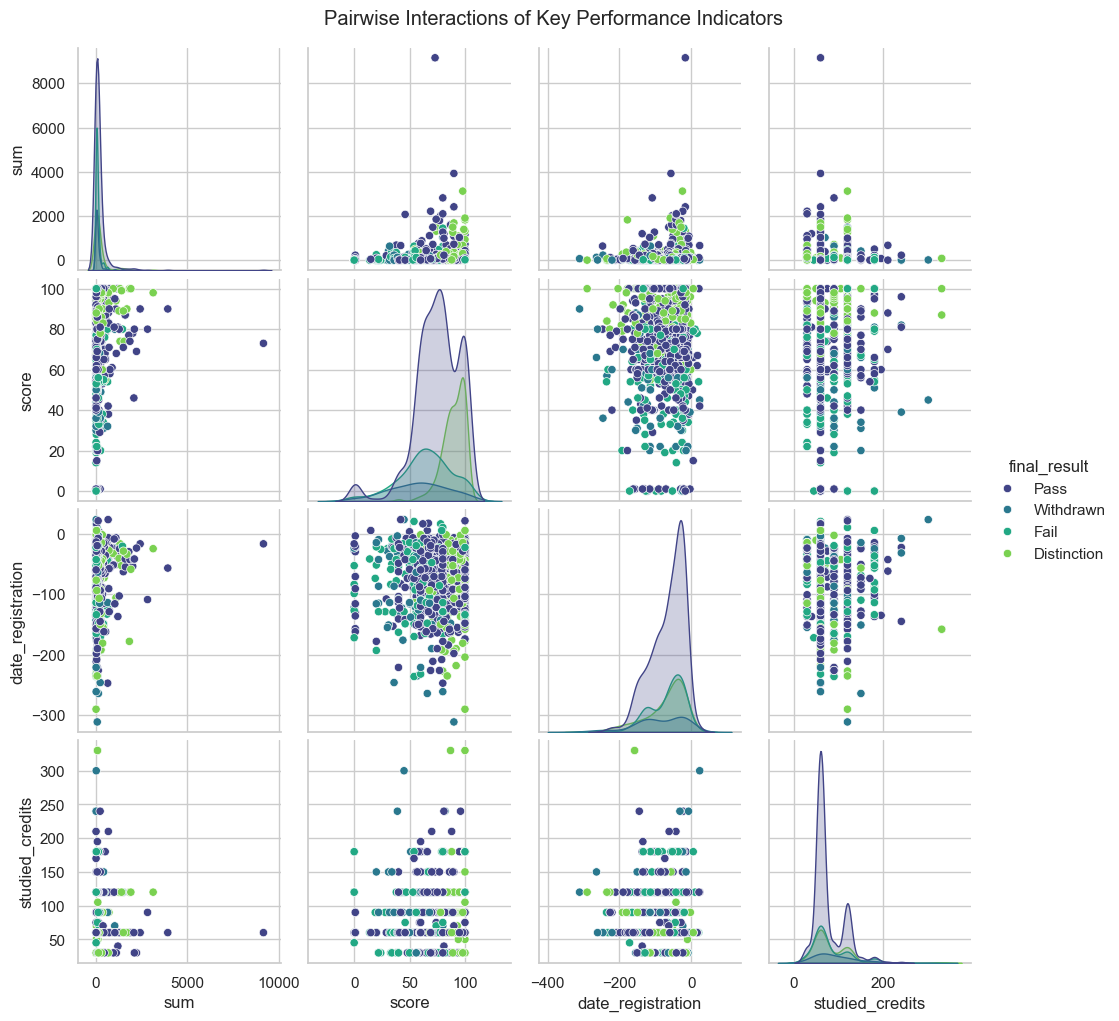

In [182]:
# --- PAIR PLOT: INTERACTION BETWEEN KEY METRICS ---
# Use the final combined dataframe that contains the 'sum' (engagement) column
key_vars = ['sum', 'score', 'date_registration', 'studied_credits', 'final_result']

# Plotting using the correct dataframe variable
sns.pairplot(student_engagement_analysis_df[key_vars].sample(1000, random_state=42),
             hue='final_result',
             palette='viridis',
             diag_kind='kde')

plt.suptitle('Pairwise Interactions of Key Performance Indicators', y=1.02)
plt.show()

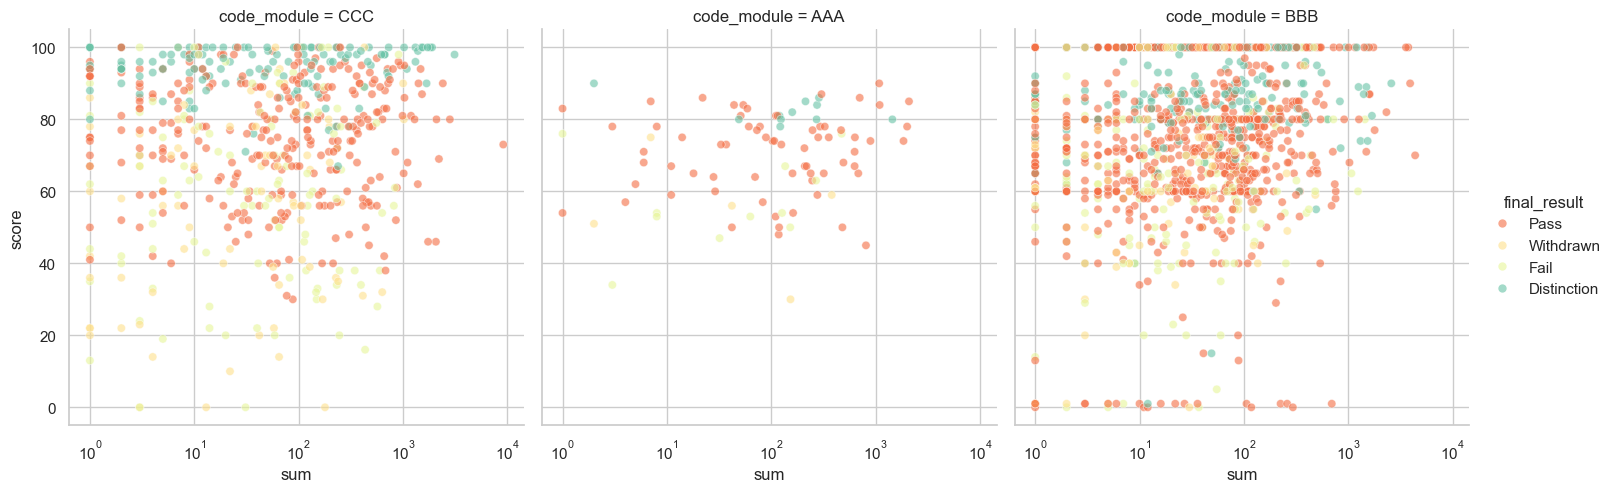

In [183]:
# --- FACETED SCATTER PLOT: ENGAGEMENT VS. SCORE BY MODULE ---
# Does the impact of VLE clicks on scores change depending on the course?

# Use the final combined dataframe that includes the 'sum' (VLE clicks) column
sns.relplot(
    data=student_engagement_analysis_df.sample(2000, random_state=42),
    x='sum', y='score',
    hue='final_result',
    col='code_module',
    col_wrap=3,
    palette='Spectral',
    alpha=0.6
)

plt.xscale('log') # Log scale for clicks
plt.show()

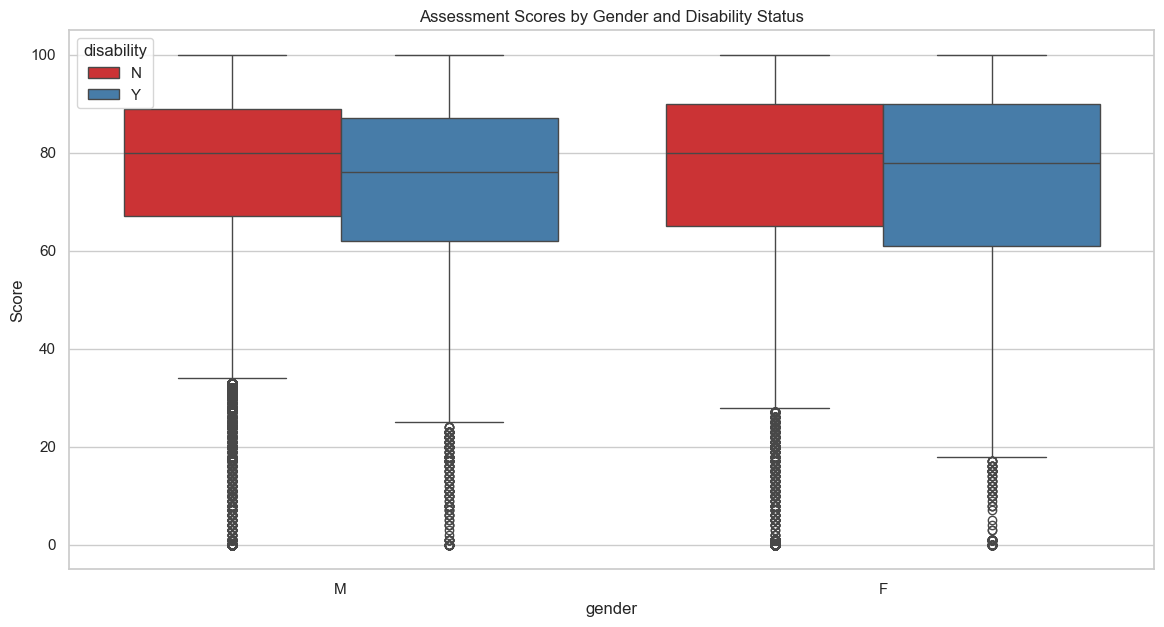

In [184]:
# --- MULTI-CATEGORICAL ANALYSIS: SCORE BY DISABILITY AND GENDER ---
# Examining distribution differences across multiple demographic categories
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='gender', y='score', hue='disability', palette='Set1')
plt.title('Assessment Scores by Gender and Disability Status')
plt.ylabel('Score')
plt.show()

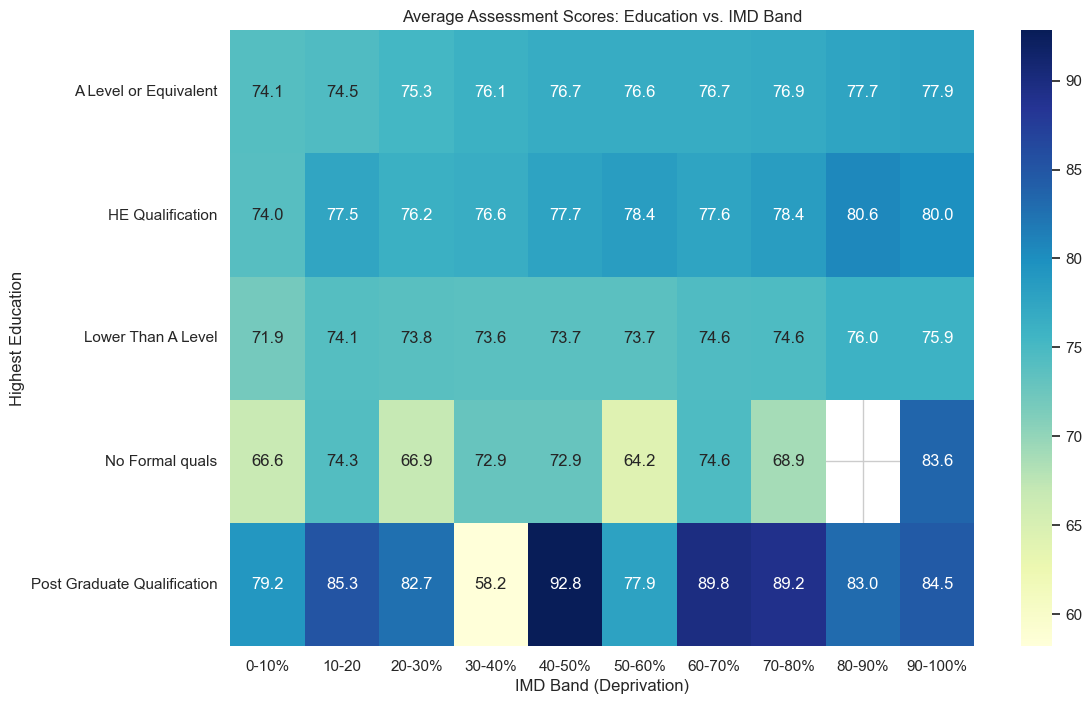

In [185]:
# --- HEATMAP: PERFORMANCE BY EDUCATION AND DEPRAVATION (IMD BAND) ---
# Aggregating data to see "heat" zones of success or risk
pivot_data = df.pivot_table(
    values='score',
    index='highest_education',
    columns='imd_band',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average Assessment Scores: Education vs. IMD Band')
plt.xlabel('IMD Band (Deprivation)')
plt.ylabel('Highest Education')
plt.show()

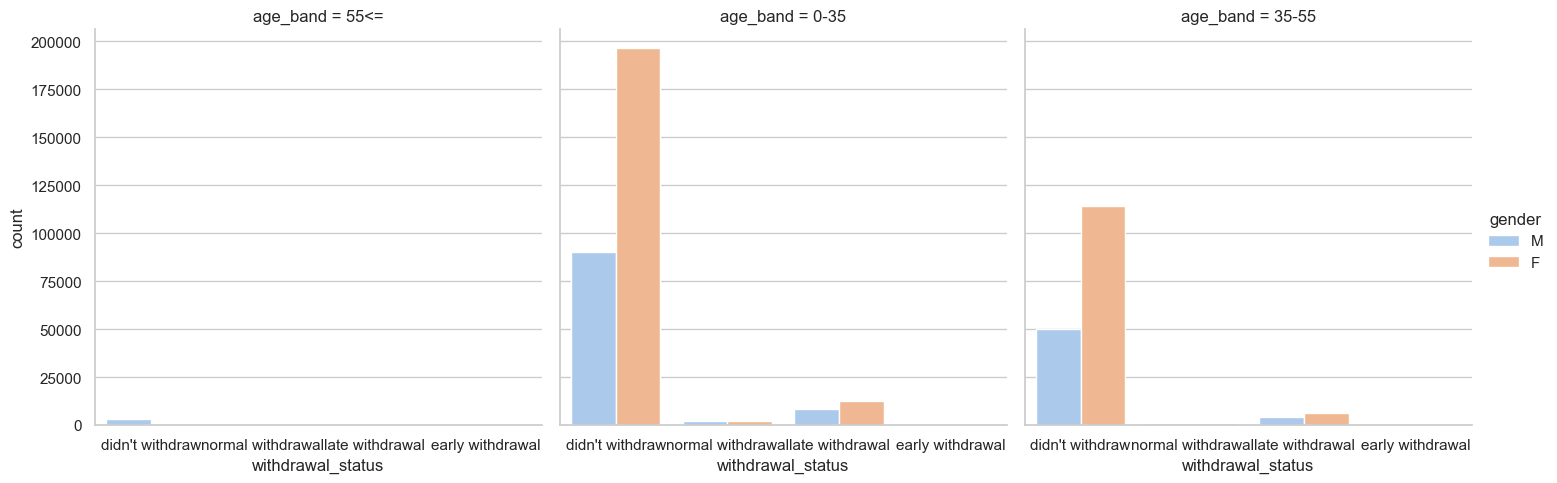

In [186]:
# --- FACETED CATEGORICAL PLOT: WITHDRAWAL TIMING BY AGE AND GENDER ---
# Visualizing how demographic combinations affect unregistration patterns

# Use the final combined dataframe
sns.catplot(
    data=student_engagement_analysis_df,
    x='withdrawal_status',
    hue='gender',
    col='age_band',
    kind='count',
    palette='pastel'
)

plt.show()

# **OUTLIER DETECTION AND DETAILED DISTRIBUTION**

In [187]:
# Quantification of Outliers in Engagement and Scores
def detect_outliers_iqr(column):
    Q1 = student_engagement_analysis_df[column].quantile(0.25)
    Q3 = student_engagement_analysis_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = student_engagement_analysis_df[(student_engagement_analysis_df[column] < lower_bound) | (student_engagement_analysis_df[column] > upper_bound)]
    return len(outliers), (len(outliers) / len(student_engagement_analysis_df)) * 100

for col in ['sum', 'score']:
    count, perc = detect_outliers_iqr(col)
    print(f"Column {col}: {count} outliers found ({perc:.2f}%)")

Column sum: 58190 outliers found (11.82%)
Column score: 12090 outliers found (2.46%)


# **TEMPORAL ANALYSIS (LEARNING OVER TIME)**

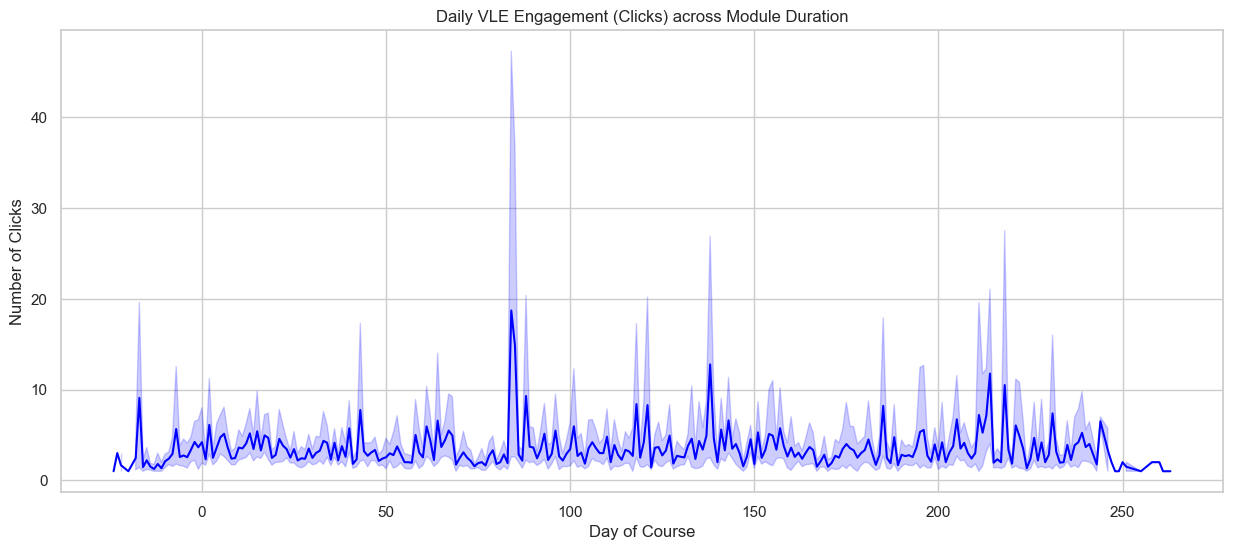

In [188]:
# Trend of engagement across all students over the duration of the module
plt.figure(figsize=(15, 6))
sns.lineplot(data=student_vle_interactions.sample(5000), x='date', y='sum_click', color='blue')
plt.title('Daily VLE Engagement (Clicks) across Module Duration')
plt.xlabel('Day of Course')
plt.ylabel('Number of Clicks')
plt.show()

# **VLE ACTIVITY-TYPE SPECIFICITY**

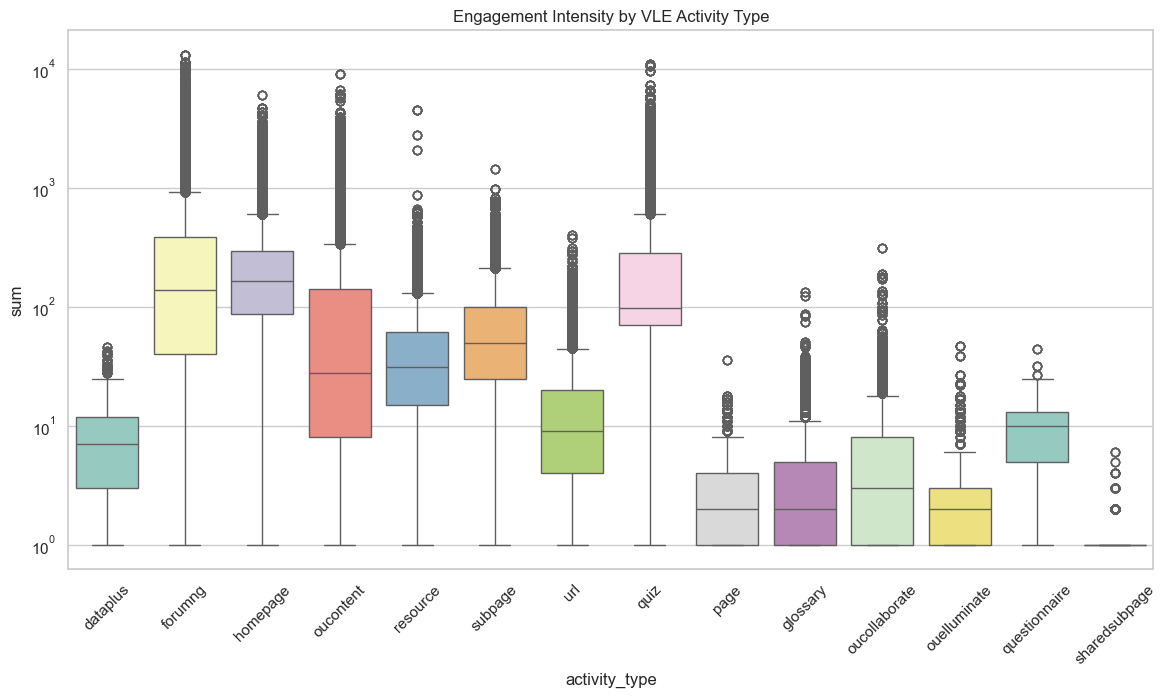

In [189]:
# Compare engagement density across activity types
plt.figure(figsize=(14, 7))
sns.boxplot(data=student_engagement_analysis_df, x='activity_type', y='sum', palette='Set3')
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Engagement Intensity by VLE Activity Type')
plt.show()

# **TARGET VARIABLE IMBALANCE CHECK**

<Figure size 1200x600 with 0 Axes>

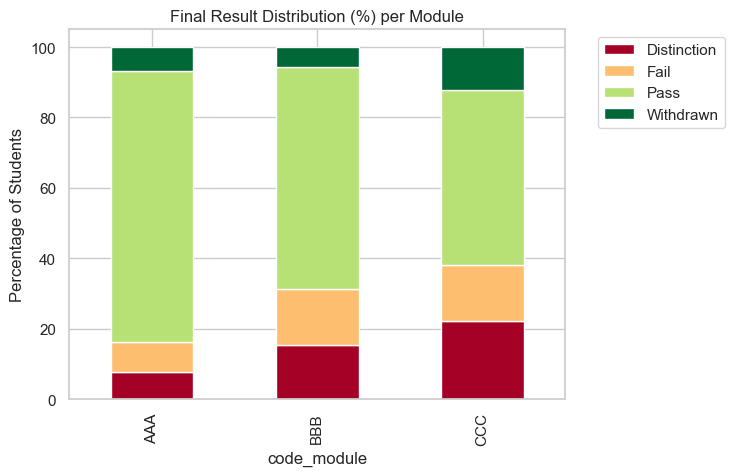

In [190]:
# Percentage Success Rate per Module
plt.figure(figsize=(12, 6))
module_success = pd.crosstab(student_engagement_analysis_df['code_module'],
                             student_engagement_analysis_df['final_result'],
                             normalize='index') * 100
module_success.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Final Result Distribution (%) per Module')
plt.ylabel('Percentage of Students')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## FEATURE ENGINEERING: TIME-BASED METRICS


In [191]:
student_engagement_analysis_df.rename(columns={'date_registration': 'days_since_registration_start'}, inplace=True) # Renames the 'date_registration' column for clarity
print("Column 'date_registration' renamed to 'days_since_registration_start'.")

Column 'date_registration' renamed to 'days_since_registration_start'.


In [192]:
days_to_first_activity_df = studentvle.groupby(['id_student', 'code_module', 'code_presentation'])['date'].min().reset_index() # Calculates the earliest VLE interaction date for each student per module presentation
days_to_first_activity_df.rename(columns={'date': 'days_to_first_activity'}, inplace=True) # Renames the 'date' column to 'days_to_first_activity'
student_engagement_analysis_df = pd.merge(
    student_engagement_analysis_df,
    days_to_first_activity_df,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left' # Merges this new feature into the main DataFrame
)
print("'days_to_first_activity' calculated and merged.")

'days_to_first_activity' calculated and merged.


In [193]:
total_clicks_df = studentvle.groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index() # Aggregates total clicks for each student per module presentation
total_clicks_df.rename(columns={'sum_click': 'total_vle_clicks_per_module'}, inplace=True) # Renames the 'sum_click' column
student_engagement_analysis_df = pd.merge(
    student_engagement_analysis_df,
    total_clicks_df,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left' # Merges the total clicks into the main DataFrame
)
student_engagement_analysis_df['average_daily_clicks'] = student_engagement_analysis_df['total_vle_clicks_per_module'] / student_engagement_analysis_df['module_presentation_length'] # Calculates average daily clicks
print("'average_daily_clicks' calculated and merged.")

'average_daily_clicks' calculated and merged.


In [194]:
student_engagement_analysis_df['time_to_submission'] = student_engagement_analysis_df['date_submitted'] - student_engagement_analysis_df['date'] # Calculates the difference between assessment submission date and assessment date
print("'time_to_submission' calculated.")

'time_to_submission' calculated.


## GEOGRAPHIC AND SOCIOECONOMIC IMPACT ON PERFORMANCE


In [195]:
region_imd_score_pivot = student_engagement_analysis_df.pivot_table(
    values='score',
    index='region',
    columns='imd_band',
    aggfunc='mean'
) # Creates a pivot table to show the average assessment score for each combination of region and IMD band
print("Pivot table for average score by region and IMD band created.")

Pivot table for average score by region and IMD band created.


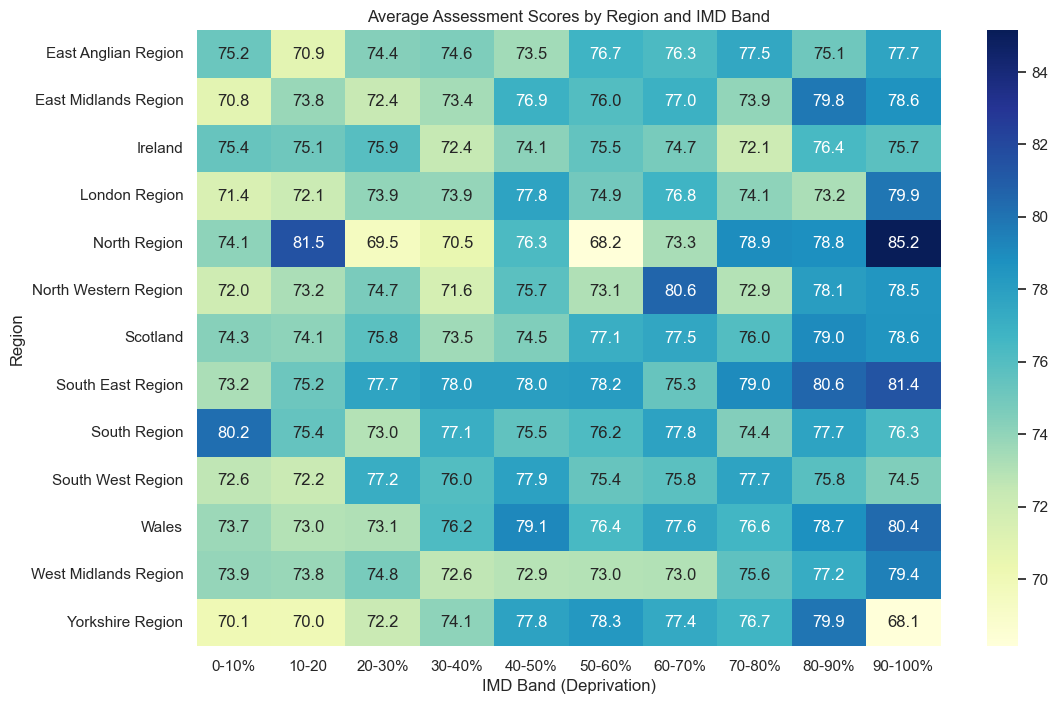

Heatmap generated for average assessment scores by region and IMD band.


In [196]:
plt.figure(figsize=(12, 8))
sns.heatmap(region_imd_score_pivot, annot=True, cmap='YlGnBu', fmt=".1f") # Generates a heatmap to visualize the average assessment scores across regions and IMD bands
plt.title('Average Assessment Scores by Region and IMD Band') # Sets the title of the heatmap
plt.xlabel('IMD Band (Deprivation)') # Labels the x-axis
plt.ylabel('Region') # Labels the y-axis
plt.show() # Displays the plot
print("Heatmap generated for average assessment scores by region and IMD band.")

In [197]:
region_final_result_cross_tab = pd.crosstab(student_engagement_analysis_df['region'], student_engagement_analysis_df['final_result'], normalize='index') * 100 # Creates a cross-tabulation to show the percentage distribution of final results within each region
print("Cross-tabulation for final result distribution by region created.")

Cross-tabulation for final result distribution by region created.


<Figure size 1400x700 with 0 Axes>

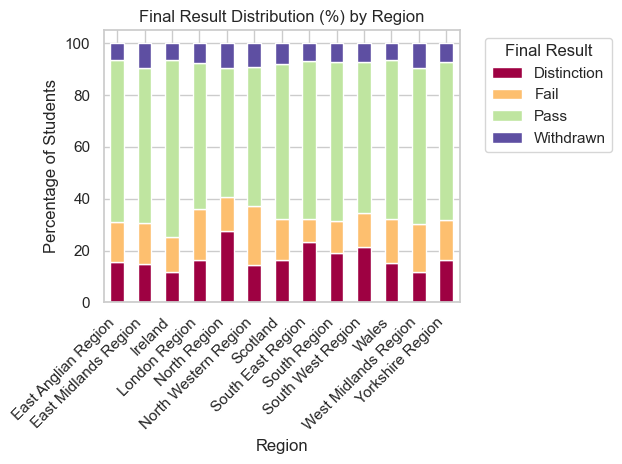

Stacked bar chart generated for final result distribution by region.


In [198]:
plt.figure(figsize=(14, 7))
region_final_result_cross_tab.plot(kind='bar', stacked=True, colormap='Spectral') # Plots a stacked bar chart to visualize the final result distribution by region
plt.title('Final Result Distribution (%) by Region') # Sets the title of the chart
plt.xlabel('Region') # Labels the x-axis
plt.ylabel('Percentage of Students') # Labels the y-axis
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left') # Adds a legend outside the plot area
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels for better readability
plt.tight_layout() # Adjusts plot to ensure all elements fit
plt.show() # Displays the plot
print("Stacked bar chart generated for final result distribution by region.")

In [199]:
imd_final_result_cross_tab = pd.crosstab(student_engagement_analysis_df['imd_band'], student_engagement_analysis_df['final_result'], normalize='index') * 100 # Creates a cross-tabulation to show the percentage distribution of final results within each IMD band
print("Cross-tabulation for final result distribution by IMD band created.")

Cross-tabulation for final result distribution by IMD band created.


<Figure size 1400x700 with 0 Axes>

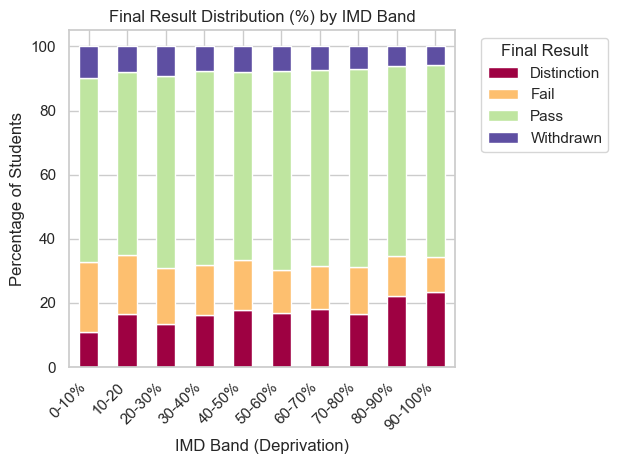

Stacked bar chart generated for final result distribution by IMD band.


In [200]:
plt.figure(figsize=(14, 7))
imd_final_result_cross_tab.plot(kind='bar', stacked=True, colormap='Spectral') # Plots a stacked bar chart to visualize the final result distribution by IMD band
plt.title('Final Result Distribution (%) by IMD Band') # Sets the title of the chart
plt.xlabel('IMD Band (Deprivation)') # Labels the x-axis
plt.ylabel('Percentage of Students') # Labels the y-axis
plt.legend(title='Final Result', bbox_to_anchor=(1.05, 1), loc='upper left') # Adds a legend outside the plot area
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels for better readability
plt.tight_layout() # Adjusts plot to ensure all elements fit
plt.show() # Displays the plot
print("Stacked bar chart generated for final result distribution by IMD band.")

## MODULE-SPECIFIC PERFORMANCE AND ENGAGEMENT TRENDS


In [201]:
average_scores_df = student_engagement_analysis_df.groupby(['code_module', 'code_presentation'])['score'].mean().reset_index() # Groups data by module and presentation to calculate the average score
average_scores_df.rename(columns={'score': 'average_score'}, inplace=True) # Renames the score column for clarity
print("Average scores per module and presentation calculated.")

Average scores per module and presentation calculated.


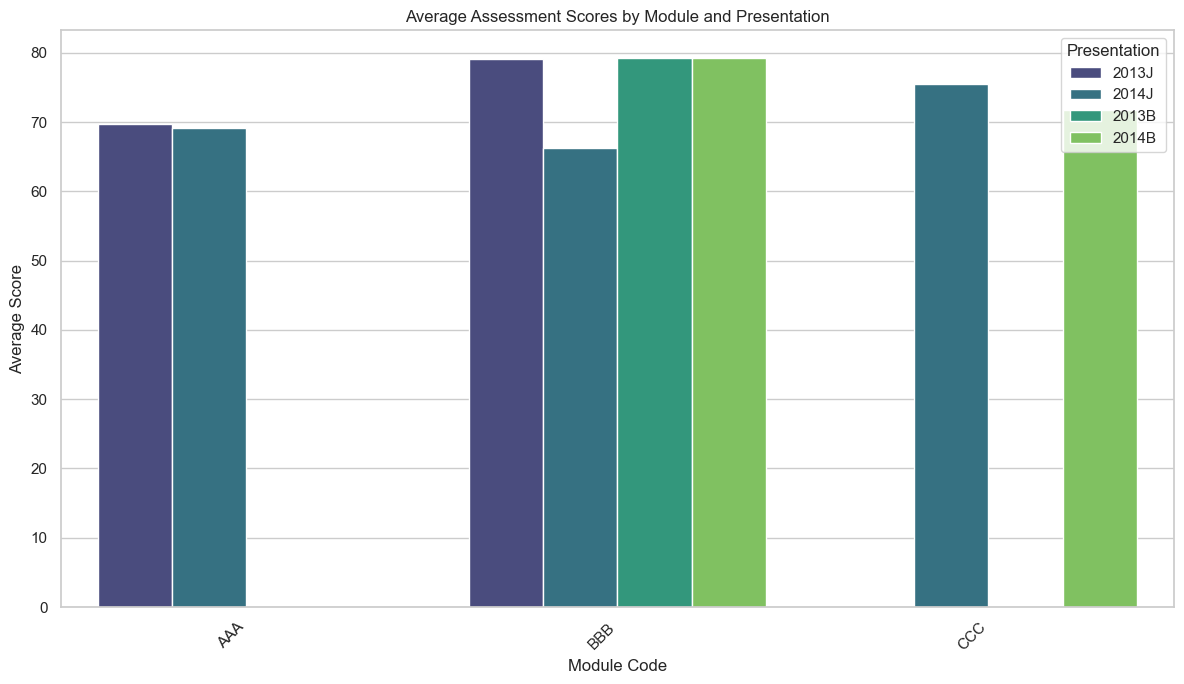

Grouped bar chart for average assessment scores generated.


In [202]:
plt.figure(figsize=(12, 7))
sns.barplot(data=average_scores_df, x='code_module', y='average_score', hue='code_presentation', palette='viridis') # Creates a grouped bar chart to visualize average assessment scores
plt.title('Average Assessment Scores by Module and Presentation') # Sets the chart title
plt.xlabel('Module Code') # Labels the x-axis
plt.ylabel('Average Score') # Labels the y-axis
plt.legend(title='Presentation') # Adds a legend for presentations
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels for readability
plt.tight_layout() # Adjusts plot layout
plt.show() # Displays the plot
print("Grouped bar chart for average assessment scores generated.")

In [203]:
average_clicks_df = student_engagement_analysis_df.groupby(['code_module', 'code_presentation'])['sum'].mean().reset_index() # Groups data by module and presentation to calculate the average clicks
average_clicks_df.rename(columns={'sum': 'average_clicks'}, inplace=True) # Renames the sum column for clarity
print("Average clicks per module and presentation calculated.")

Average clicks per module and presentation calculated.


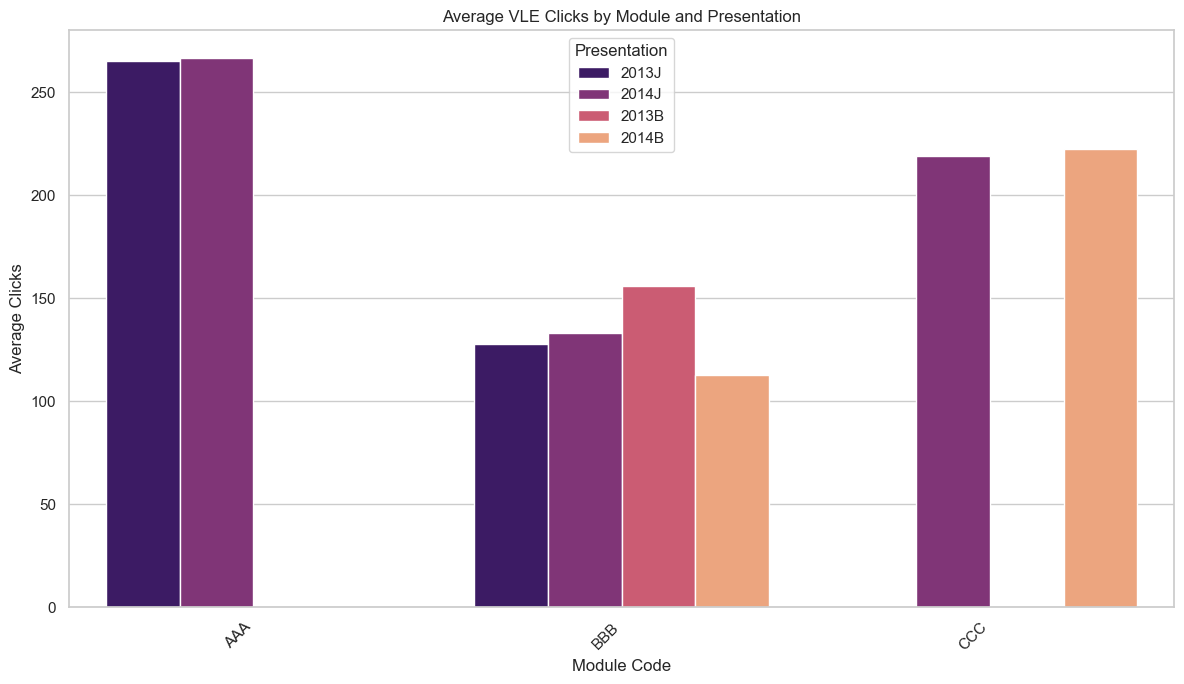

Grouped bar chart for average VLE clicks generated.


In [204]:
plt.figure(figsize=(12, 7))
sns.barplot(data=average_clicks_df, x='code_module', y='average_clicks', hue='code_presentation', palette='magma') # Creates a grouped bar chart to visualize average VLE clicks
plt.title('Average VLE Clicks by Module and Presentation') # Sets the chart title
plt.xlabel('Module Code') # Labels the x-axis
plt.ylabel('Average Clicks') # Labels the y-axis
plt.legend(title='Presentation') # Adds a legend for presentations
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels for readability
plt.tight_layout() # Adjusts plot layout
plt.show() # Displays the plot
print("Grouped bar chart for average VLE clicks generated.")

In [205]:
pass_rates_df = student_engagement_analysis_df.groupby(['code_module', 'code_presentation'])['final_result'].apply(lambda x: (x == 'Pass').mean()).reset_index() # Groups data by module and presentation to calculate the pass rate
pass_rates_df.rename(columns={'final_result': 'pass_rate'}, inplace=True) # Renames the final_result column for clarity
print("Pass rates per module and presentation calculated.")

Pass rates per module and presentation calculated.


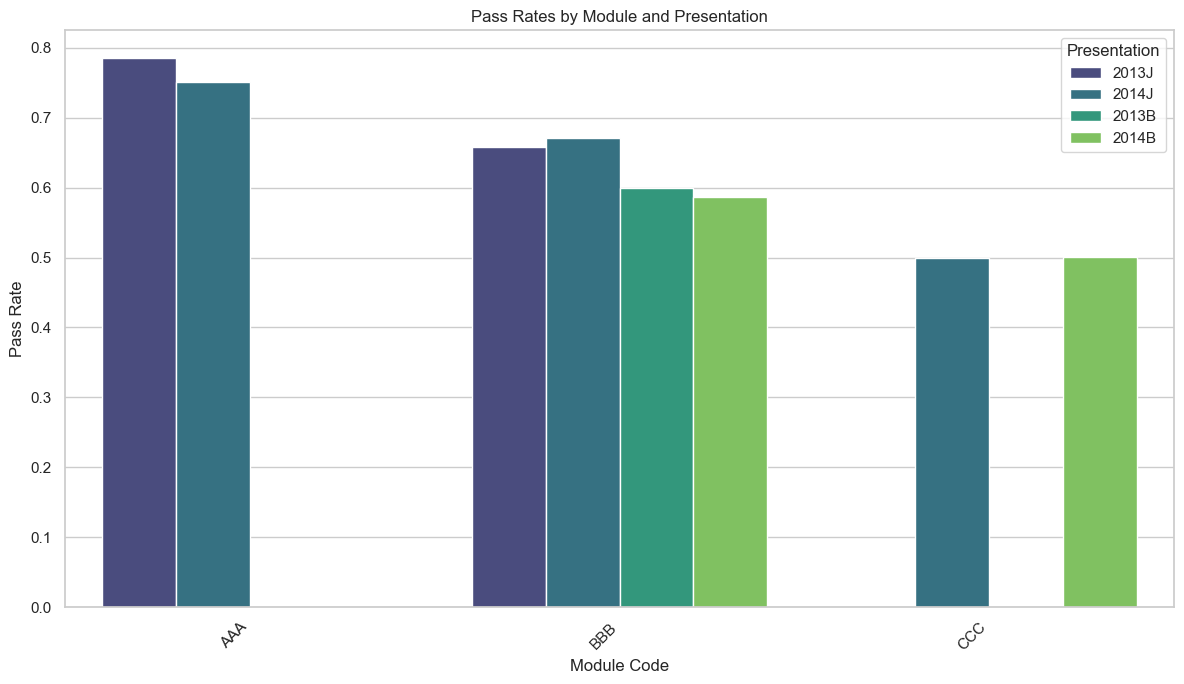

Grouped bar chart for pass rates generated.


In [206]:
plt.figure(figsize=(12, 7))
sns.barplot(data=pass_rates_df, x='code_module', y='pass_rate', hue='code_presentation', palette='viridis') # Creates a grouped bar chart to visualize pass rates
plt.title('Pass Rates by Module and Presentation') # Sets the chart title
plt.xlabel('Module Code') # Labels the x-axis
plt.ylabel('Pass Rate') # Labels the y-axis
plt.legend(title='Presentation') # Adds a legend for presentations
plt.xticks(rotation=45, ha='right') # Rotates x-axis labels for readability
plt.tight_layout() # Adjusts plot layout
plt.show() # Displays the plot
print("Grouped bar chart for pass rates generated.")

# **KEY OBSERVATIONS AND CONCLUSIONS FROM EXPLORATORY DATA ANALYSIS**

1.  The dataset exhibits a class imbalance in final outcomes, with a significantly higher proportion of students achieving Pass results compared to Fail and Distinction, while a substantial number of students withdraw before module completion.

2.  Students who complete the module generally demonstrate higher engagement levels (measured through VLE clicks and activity counts) compared to those who withdraw early.

3.  Withdrawal behavior is time-dependent, with most withdrawals occurring during the mid to later stages of the module rather than at the very beginning.

4.  Assessment scores show a strong positive association with final results, where higher continuous assessment performance is linked to passing or achieving distinctions.

5.  Students who withdraw tend to have lower or missing assessment scores, indicating disengagement or non-participation prior to withdrawal.

6.  Demographic factors such as highest education level and age band display noticeable variation in academic outcomes, suggesting their potential influence on student success.

7.  Gender-based differences in final outcomes are relatively small, indicating limited impact compared to academic and engagement-related features.

8.  Prior academic history, measured through the number of previous attempts, shows a mild negative relationship with final performance, where repeated attempts are associated with higher withdrawal or failure rates.

9.  Engagement metrics derived from VLE interactions demonstrate moderate correlation with assessment scores, reinforcing the importance of online participation in academic success.

10.  Certain modules and presentations exhibit systematic differences in completion and performance rates, highlighting the role of course structure and delivery in student outcomes.

11.  Numerical features such as scores and engagement counts show skewed distributions with outliers, justifying the need for careful feature scaling and transformation in downstream modeling.

12.  Correlation analysis indicates no severe multicollinearity among most numerical variables, making the dataset suitable for predictive modeling approaches.

13.  Overall, student engagement and assessment performance emerge as the strongest predictors of final outcomes, outweighing purely demographic characteristics.

# **EARLY INTERVENTION MODELING**

## FEATURE ENGINEERING: Advanced Engagement and Performance Metrics

In [207]:
# Feature Engineering on student_engagement_analysis_df (for EDA)

# 1. Engagement & Performance Metrics
student_engagement_analysis_df['assessment_engagement_score'] = student_engagement_analysis_df['sum'] * student_engagement_analysis_df['count']
student_engagement_analysis_df['submission_timeliness'] = student_engagement_analysis_df['date_submitted'] - student_engagement_analysis_df['date']
student_engagement_analysis_df['score_per_weight'] = student_engagement_analysis_df['score'] / (student_engagement_analysis_df['weight'] + 1)
student_engagement_analysis_df['module_engagement_rate'] = student_engagement_analysis_df['sum'] / student_engagement_analysis_df['module_presentation_length']

# 2. Student History & Registration
student_engagement_analysis_df['repeat_student'] = student_engagement_analysis_df['num_of_prev_attempts'].apply(lambda x: 1 if x > 0 else 0)
student_engagement_analysis_df['performance_by_registration'] = student_engagement_analysis_df['score'] / (student_engagement_analysis_df['days_since_registration_start'] + 1).replace(0, 1)
student_engagement_analysis_df['time_since_registration'] = student_engagement_analysis_df['date'] - student_engagement_analysis_df['days_since_registration_start']

# 3. Aggregations (Transform)
# Note: Using .transform keeps the original dimensions, useful for the detailed EDA dataframe
student_engagement_analysis_df['banked_assessment_ratio'] = student_engagement_analysis_df.groupby('id_student')['is_banked'].transform(lambda x: x.sum() / x.count() if x.count() > 0 else 0)
student_engagement_analysis_df['cumulative_score'] = student_engagement_analysis_df.groupby('id_student')['score'].cumsum()
student_engagement_analysis_df['engagement_consistency'] = student_engagement_analysis_df.groupby('id_student')['sum'].transform(lambda x: x.std() if len(x) > 1 else 0)
student_engagement_analysis_df['learning_pace'] = student_engagement_analysis_df.groupby('id_student')['date_submitted'].diff().fillna(0)
student_engagement_analysis_df['engagement_dropoff'] = student_engagement_analysis_df.groupby('id_student')['sum'].transform(lambda x: (x.max() - x.min()) / (x.count() - 1) if x.count() > 1 else 0)
student_engagement_analysis_df['activity_diversity'] = student_engagement_analysis_df.groupby('id_student')['activity_type'].transform('nunique')
student_engagement_analysis_df['improvement_rate'] = student_engagement_analysis_df.groupby('id_student')['score'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / (x.count() - 1) if x.count() > 1 else 0)

# 4. Weighted Metrics
student_engagement_analysis_df['weighted_engagement'] = student_engagement_analysis_df['assessment_engagement_score'] * student_engagement_analysis_df['weight']

print("Feature engineering (EDA) completed.")

Feature engineering (EDA) completed.


### Displaying DataFrame with New Features

In [208]:
display(student_engagement_analysis_df.head())
display(student_engagement_analysis_df.info())

,id_student,code_module,code_presentation,activity_type,sum,count,id_assessment,assessment_type,date,weight,...,performance_by_registration,time_since_registration,banked_assessment_ratio,cumulative_score,engagement_consistency,learning_pace,engagement_dropoff,activity_diversity,improvement_rate,weighted_engagement
0,6516,AAA,2014J,dataplus,21,4,1758,TMA,19.0,10.0,...,-1.176471,71.0,0.0,60.0,491.833818,0.0,43.647059,7,0.5,840.0
1,6516,AAA,2014J,dataplus,21,4,1759,TMA,54.0,20.0,...,-0.941176,106.0,0.0,108.0,491.833818,34.0,43.647059,7,0.5,1680.0
2,6516,AAA,2014J,dataplus,21,4,1760,TMA,117.0,20.0,...,-1.235294,169.0,0.0,171.0,491.833818,65.0,43.647059,7,0.5,1680.0
3,6516,AAA,2014J,dataplus,21,4,1761,TMA,166.0,20.0,...,-1.196078,218.0,0.0,232.0,491.833818,48.0,43.647059,7,0.5,1680.0
4,6516,AAA,2014J,dataplus,21,4,1762,TMA,215.0,30.0,...,-1.509804,267.0,0.0,309.0,491.833818,46.0,43.647059,7,0.5,2520.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492117 entries, 0 to 492116
Data columns (total 46 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id_student                     492117 non-null  int64  
 1   code_module                    492117 non-null  object 
 2   code_presentation              492117 non-null  object 
 3   activity_type                  492117 non-null  object 
 4   sum                            492117 non-null  int64  
 5   count                          492117 non-null  int64  
 6   id_assessment                  492117 non-null  int64  
 7   assessment_type                492117 non-null  object 
 8   date                           492117 non-null  float64
 9   weight                         492117 non-null  float64
 10  date_submitted                 492117 non-null  int64  
 11  is_banked                      492117 non-null  int64  
 12  score                         

None

## DATA AGGREGATION FOR MODELING


In [209]:
# 1. Aggregate Assessment Data (One row per student-module)
# Calculate weighted average score as the Target Variable or key performance feature
assessment_agg = student_data.groupby(['id_student', 'code_module', 'code_presentation']).apply(
    lambda x: pd.Series({
        'final_weighted_score': (x['score'] * x['weight']).sum() / x['weight'].sum() if x['weight'].sum() > 0 else 0,
        'average_assessment_score': x['score'].mean(),
        'submission_timeliness_avg': (x['date_submitted'] - x['date']).mean(),
        'assessments_completed': x['id_assessment'].count()
    })
).reset_index()

print("Assessment data aggregated.")

Assessment data aggregated.


In [210]:
# Define the cutoff day for early prediction
CUTOFF_DAY = 90

print(f"Preparing data for Early Intervention Model (Data up to Day {CUTOFF_DAY})...")

# 1. Filter VLE Data (Activity before cutoff)
early_vle = studentvle[studentvle['date'] <= CUTOFF_DAY]

early_vle_agg = early_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    early_total_clicks=('sum_click', 'sum'),
    early_activity_count=('date', 'count'),
    early_last_active=('date', 'max')
).reset_index()

# 2. Filter Assessment Data (Submitted before cutoff)
# Note: We still want to predict the *Final* Weighted Score, so we don't change the target 'y'.
# But the features must only include assessments submitted by the cutoff.
early_assessments = student_data[student_data['date_submitted'] <= CUTOFF_DAY]

early_assessment_agg = early_assessments.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    early_score_avg=('score', 'mean'),
    early_assessments_done=('id_assessment', 'count')
).reset_index()

# 3. Merge into Early Model DataFrame
early_model_df = studentinfo.copy()
early_model_df = early_model_df.merge(early_vle_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')
early_model_df = early_model_df.merge(early_assessment_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Merge the TARGET variable (Final Weighted Score) from the original full aggregation
# We need the final outcome to train the model, even if features are early.
target_df = assessment_agg[['id_student', 'code_module', 'code_presentation', 'final_weighted_score']]
early_model_df = early_model_df.merge(target_df, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Fill NaNs (Students with no activity by Day 90)
early_model_df.fillna(0, inplace=True)

print(f"Early Intervention Dataset Shape: {early_model_df.shape}")
display(early_model_df.head())

Preparing data for Early Intervention Model (Data up to Day 90)...
Early Intervention Dataset Shape: (32593, 18)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,early_total_clicks,early_activity_count,early_last_active,early_score_avg,early_assessments_done,final_weighted_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,587.0,108.0,87.0,81.5,2.0,82.4
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,821.0,230.0,90.0,69.0,2.0,65.4
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,76.0,12.0,0.0,0.0,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,992.0,296.0,90.0,71.5,2.0,76.3
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,684.0,189.0,90.0,49.5,2.0,55.0


In [211]:
# 2. Aggregate VLE Engagement Data (One row per student-module)
vle_agg = student_activity_engagement.groupby(['id_student', 'code_module', 'code_presentation']).agg(
    total_clicks=('sum', 'sum'),
    total_activities=('count', 'sum'),
    activity_diversity=('activity_type', 'count') # Count of unique activity types utilized
).reset_index()

print("VLE data aggregated.")

VLE data aggregated.


In [212]:
# 3. Merge into a single Model Dataset
# Start with Student Info (Demographics)
model_df = studentinfo.copy()

# Merge Assessment Aggregates
model_df = model_df.merge(assessment_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Merge VLE Aggregates
model_df = model_df.merge(vle_agg, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Merge Registration Info
model_df = model_df.merge(studentregistration, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Fill NaN values for students with no activity/assessments (yet)
model_df.fillna(0, inplace=True)

print(f"Final Model Dataset Shape: {model_df.shape}")
display(model_df.head())

Final Model Dataset Shape: (32593, 21)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,final_result,final_weighted_score,average_assessment_score,submission_timeliness_avg,assessments_completed,total_clicks,total_activities,activity_diversity,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,Pass,82.4,82.0,-1.8,5.0,934.0,196.0,6.0,-159.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,Pass,65.4,66.4,0.0,5.0,1435.0,430.0,7.0,-53.0,0.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,Withdrawn,0.0,0.0,0.0,0.0,281.0,76.0,6.0,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,Pass,76.3,76.0,-2.0,5.0,2158.0,663.0,8.0,-52.0,0.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,Pass,55.0,54.4,11.4,5.0,1034.0,352.0,7.0,-176.0,0.0


## RE-APPLYING FEATURE ENGINEERING


In [213]:
# Engineering features on the clean student-level dataset

# Engagement Intensity
model_df['engagement_intensity'] = model_df['total_clicks'] / (model_df['total_activities'] + 1)

# Registration Timing (Negative values = Days before start)
model_df['days_since_registration'] = model_df['date_registration'] # keeping raw value as it's meaningful

# Performance vs Engagement Ratio
model_df['performance_click_ratio'] = model_df['final_weighted_score'] / (model_df['total_clicks'] + 1)

# Interaction per Assessment
model_df['clicks_per_assessment'] = model_df['total_clicks'] / (model_df['assessments_completed'] + 1)

display(model_df[['id_student', 'final_weighted_score', 'total_clicks', 'performance_click_ratio']].head())

,id_student,final_weighted_score,total_clicks,performance_click_ratio
0,11391,82.4,934.0,0.088128
1,28400,65.4,1435.0,0.045543
2,30268,0.0,281.0,0.000000
3,31604,76.3,2158.0,0.035340
4,32885,55.0,1034.0,0.053140


In [214]:
early_model_df

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,early_total_clicks,early_activity_count,early_last_active,early_score_avg,early_assessments_done,final_weighted_score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,587.0,108.0,87.0,81.5,2.0,82.4
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,821.0,230.0,90.0,69.0,2.0,65.4
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,76.0,12.0,0.0,0.0,0.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,992.0,296.0,90.0,71.5,2.0,76.3
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,684.0,189.0,90.0,49.5,2.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,0.0,0.0,0.0,0.0,0.0,0.0
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,0.0,0.0,0.0,80.0,1.0,0.0
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,0.0,0.0,0.0,65.0,1.0,0.0
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,0.0,0.0,0.0,91.5,2.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Scikit-learn libraries for model building, scaling, grid search, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Prepare Early Data for Modeling
early_ml_data = early_model_df.copy()

# Drop identifiers and leakage columns
# 'final_result' is categorical target, 'date_unregistration' is leakage
cols_to_drop_early = ['id_student', 'date_unregistration']
early_ml_data = early_ml_data.drop(columns=cols_to_drop_early, errors='ignore')

# Identify categorical columns automatically
categorical_cols = early_ml_data.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
le = LabelEncoder()

# Encode Categoricals
for col in categorical_cols:
    if col in early_ml_data.columns:
        early_ml_data[col] = le.fit_transform(early_ml_data[col].astype(str))

# Split Features and Target
X_early = early_ml_data.drop(columns=['final_weighted_score', 'final_result'])
y_early = early_ml_data['final_result']

# Train-Test Split
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_early, y_early, test_size=0.2, random_state=42)

# Step 1: Scale the data for SVM.
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_e)
X_test_svm_scaled = scaler_svm.transform(X_test_e)

# Step 2: Define the SVM classifier.
svm = SVC()

# Define a hyperparameter grid for SVM.
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, param_grid=param_grid_svm,
                        cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_svm_scaled, y_train_e)

print("\n--- SVM Results ---")
print("Best SVM parameters:", grid_svm.best_params_)
print("Best cross-validation accuracy for SVM: {:.4f}".format(grid_svm.best_score_))

In [219]:
early_model_df['final_result']

0               Pass
1               Pass
2          Withdrawn
3               Pass
4               Pass
            ...     
32588           Fail
32589    Distinction
32590           Pass
32591      Withdrawn
32592    Distinction
Name: final_result, Length: 32593, dtype: object

In [ ]:

final_svm_model = grid_svm.best_estimator_

# Evaluate the final explicit SVM model on the test set.
y_pred_final_svm = final_svm_model.predict(X_test_svm_scaled)
print("\nFinal SVM Model (explicit) - Classification Report:")
print(classification_report(y_test_e, y_pred_final_svm))

In [ ]:
# Evaluate the best SVM model on the test set.
y_pred_svm = grid_svm.predict(X_test_svm_scaled)
cm_svm = confusion_matrix(y_test_e, y_pred_svm)

print("\nClassification Report for SVM:")
print(classification_report(y_test_e, y_pred_svm))


print("Confusion Matrix for SVM:\n", cm_svm)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **EARLY INTERVENTION ANALYSIS**

## 1. Feature Importance (Early Stage)
We visualize the feature importance to understand which early behaviors (up to Day 90) are the strongest signals of final success.

In [ ]:
from sklearn.inspection import permutation_importance

best_svm_model = grid_svm.best_estimator_

results = permutation_importance(best_svm_model, X_train_svm_scaled, y_train_e,
                                 scoring='accuracy', n_jobs=-1, n_repeats=10, random_state=42)

svm_importances = pd.DataFrame({
    'feature': X_early.columns,
    'importance': results.importances_mean
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=svm_importances.head(15), x='importance', y='feature', palette='magma')
plt.title('Top 15 Feature Importances for SVM (Permutation Method)')
plt.xlabel('Mean Importance (Drop in Accuracy)')
plt.ylabel('Feature')
plt.show()